In [121]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import nmrglue as ng
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 50000

# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = "MLP-Lipid_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/ModelPerformanceMetrics') #Save random seed used
seed = 4
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [122]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra_1 = np.load('LipidTrainTestVal_Spectra.npy')
conc1_1 = np.load('LipidTrainTestVal_Spectra_Concentrations.npy')
spectra = spectra_1[:50000]
conc1 = conc1_1[:50000]
# Select validation dataset
spectraVal = spectra_1[50000:]
concVal = conc1_1[50000:]

# Load experimental lipid mixture validation spectra
ExpValSpectra = np.load("ExperimentalLipidMixture_Spectra.npy")
ExpValConc = np.load("ExperimentalLipidMixture_Conc.npy")

# Load hepatic lipid extract validation spectra
LiverSpectra = np.load("LiverLipid_Spectra.npy")
#LiverConc = np.load("____.npy")


In [123]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [124]:
## Set up data for testing and training

# Split into testing and training data
X_train1, X_test1, y_train1, y_test1 = train_test_split(spectra, conc1, test_size = 0.2, random_state = 0)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train1).float()
y_train = torch.tensor(y_train1).float()
X_test = torch.tensor(X_test1).float()
y_test = torch.tensor(y_test1).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
spectraVal = torch.tensor(spectraVal).float().to(device)  
ExpValSpectra = torch.tensor(ExpValSpectra).float().to(device)   

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
concVal = torch.tensor(concVal).float().to(device)
ExpValConc = torch.tensor(ExpValConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 128, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 128, shuffle=True)

In [125]:
## Define NN model object, define some parameters, and instantiate model

# Define some model & training parameters
size_hidden1 = 200
size_hidden2 = 18
criterion = nn.MSELoss(reduction='sum')


# Define model
class NMR_Model_Lipid(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(14000, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
    def forward(self, input):
        return (self.lin2(self.relu1(self.lin1(input))))

In [126]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)

        if (epoch + 1) % 5 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')


        if test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save model when test loss improves
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)

    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag


In [127]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Lipid()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [5/50000], Train Loss: 81804.5162, Test Loss: 16850.7872
Epoch [10/50000], Train Loss: 28455.0080, Test Loss: 6268.4592
Epoch [15/50000], Train Loss: 12901.3001, Test Loss: 3007.4297
Epoch [20/50000], Train Loss: 9972.9523, Test Loss: 2333.6769
Epoch [25/50000], Train Loss: 8637.5290, Test Loss: 1976.8993
Epoch [30/50000], Train Loss: 7646.9918, Test Loss: 1780.1028
Epoch [35/50000], Train Loss: 7116.2339, Test Loss: 1761.4325
Epoch [40/50000], Train Loss: 6709.3976, Test Loss: 1590.4102
Epoch [45/50000], Train Loss: 6510.9454, Test Loss: 1533.0719
Epoch [50/50000], Train Loss: 6351.9016, Test Loss: 1503.7372
Epoch [55/50000], Train Loss: 6186.7882, Test Loss: 1557.7331
Epoch [60/50000], Train Loss: 6053.8472, Test Loss: 1457.4000
Epoch [65/50000], Train Loss: 5843.4287, Test Loss: 1521.2942
Epoch [70/50000], Train Loss: 5613.7450, Test Loss: 1418.0904
Epoch [75/50000], Train Loss: 5548.6556, Test Loss: 1449.0491
Epoch [80/50000],

Epoch [660/50000], Train Loss: 2071.5007, Test Loss: 723.3160
Epoch [665/50000], Train Loss: 2123.7506, Test Loss: 727.6304
Epoch [670/50000], Train Loss: 2099.6772, Test Loss: 705.0286
Epoch [675/50000], Train Loss: 1997.3057, Test Loss: 716.3282
Epoch [680/50000], Train Loss: 2022.8780, Test Loss: 699.9739
Epoch [685/50000], Train Loss: 2002.6112, Test Loss: 669.7305
Epoch [690/50000], Train Loss: 2001.0309, Test Loss: 687.5374
Epoch [695/50000], Train Loss: 1967.0403, Test Loss: 655.3052
Epoch [700/50000], Train Loss: 1948.7293, Test Loss: 657.7539
Epoch [705/50000], Train Loss: 1886.8882, Test Loss: 667.1796
Epoch [710/50000], Train Loss: 1850.0766, Test Loss: 664.4703
Epoch [715/50000], Train Loss: 1843.3731, Test Loss: 651.0299
Epoch [720/50000], Train Loss: 1843.7327, Test Loss: 633.8499
Epoch [725/50000], Train Loss: 1806.0883, Test Loss: 637.2542
Epoch [730/50000], Train Loss: 1798.5910, Test Loss: 638.5854
Epoch [735/50000], Train Loss: 1751.7418, Test Loss: 662.9299
Epoch [7

Epoch [1325/50000], Train Loss: 713.4962, Test Loss: 1163.4988
Epoch [1330/50000], Train Loss: 569.5069, Test Loss: 211.9466
Epoch [1335/50000], Train Loss: 613.9553, Test Loss: 239.2079
Epoch [1340/50000], Train Loss: 600.0359, Test Loss: 249.6871
Epoch [1345/50000], Train Loss: 560.3228, Test Loss: 242.9990
Epoch [1350/50000], Train Loss: 579.1544, Test Loss: 244.7997
Epoch [1355/50000], Train Loss: 540.7605, Test Loss: 228.7995
Epoch [1360/50000], Train Loss: 667.1557, Test Loss: 210.9728
Epoch [1365/50000], Train Loss: 609.3060, Test Loss: 224.8927
Epoch [1370/50000], Train Loss: 538.6145, Test Loss: 243.4965
Epoch [1375/50000], Train Loss: 547.4244, Test Loss: 233.1134
Epoch [1380/50000], Train Loss: 945.9956, Test Loss: 219.2427
Epoch [1385/50000], Train Loss: 546.4855, Test Loss: 218.8598
Epoch [1390/50000], Train Loss: 606.4464, Test Loss: 226.9676
Epoch [1395/50000], Train Loss: 573.2668, Test Loss: 212.1380
Epoch [1400/50000], Train Loss: 578.8543, Test Loss: 216.3453
Epoch [

Epoch [1990/50000], Train Loss: 368.8336, Test Loss: 202.0444
Epoch [1995/50000], Train Loss: 352.4051, Test Loss: 171.5566
Epoch [2000/50000], Train Loss: 363.4564, Test Loss: 162.1349
Epoch [2005/50000], Train Loss: 360.7616, Test Loss: 163.7889
Epoch [2010/50000], Train Loss: 323.2005, Test Loss: 180.0361
Epoch [2015/50000], Train Loss: 342.7874, Test Loss: 151.5593
Epoch [2020/50000], Train Loss: 371.7499, Test Loss: 152.3226
Epoch [2025/50000], Train Loss: 323.9653, Test Loss: 156.9727
Epoch [2030/50000], Train Loss: 359.0849, Test Loss: 146.5511
Epoch [2035/50000], Train Loss: 337.3079, Test Loss: 172.3406
Epoch [2040/50000], Train Loss: 445.5844, Test Loss: 146.3151
Epoch [2045/50000], Train Loss: 382.0163, Test Loss: 158.2148
Epoch [2050/50000], Train Loss: 397.0763, Test Loss: 165.5895
Epoch [2055/50000], Train Loss: 338.1855, Test Loss: 199.9060
Epoch [2060/50000], Train Loss: 351.6463, Test Loss: 154.2610
Epoch [2065/50000], Train Loss: 346.3221, Test Loss: 149.0328
Epoch [2

Epoch [2655/50000], Train Loss: 291.0359, Test Loss: 135.0556
Epoch [2660/50000], Train Loss: 615.5026, Test Loss: 113.7413
Epoch [2665/50000], Train Loss: 252.5446, Test Loss: 123.9955
Epoch [2670/50000], Train Loss: 238.1563, Test Loss: 156.2178
Epoch [2675/50000], Train Loss: 297.4396, Test Loss: 168.0928
Epoch [2680/50000], Train Loss: 258.7153, Test Loss: 137.7385
Epoch [2685/50000], Train Loss: 284.5667, Test Loss: 152.6006
Epoch [2690/50000], Train Loss: 263.7489, Test Loss: 114.2242
Epoch [2695/50000], Train Loss: 275.2814, Test Loss: 421.4542
Epoch [2700/50000], Train Loss: 254.7679, Test Loss: 114.7315
Epoch [2705/50000], Train Loss: 297.1209, Test Loss: 126.0189
Epoch [2710/50000], Train Loss: 239.2882, Test Loss: 121.4520
Epoch [2715/50000], Train Loss: 265.7288, Test Loss: 139.2210
Epoch [2720/50000], Train Loss: 261.6972, Test Loss: 127.0905
Epoch [2725/50000], Train Loss: 248.5646, Test Loss: 132.8225
Epoch [2730/50000], Train Loss: 356.2495, Test Loss: 986.5766
Epoch [2

Epoch [3320/50000], Train Loss: 196.4945, Test Loss: 131.1334
Epoch [3325/50000], Train Loss: 219.5826, Test Loss: 110.9843
Epoch [3330/50000], Train Loss: 300.0541, Test Loss: 233.8971
Epoch [3335/50000], Train Loss: 234.9348, Test Loss: 104.7236
Epoch [3340/50000], Train Loss: 228.1568, Test Loss: 110.3026
Epoch [3345/50000], Train Loss: 190.4562, Test Loss: 103.9464
Epoch [3350/50000], Train Loss: 207.5117, Test Loss: 96.8565
Epoch [3355/50000], Train Loss: 180.7019, Test Loss: 102.5646
Epoch [3360/50000], Train Loss: 181.2995, Test Loss: 92.7459
Epoch [3365/50000], Train Loss: 190.3642, Test Loss: 98.0289
Epoch [3370/50000], Train Loss: 195.3831, Test Loss: 107.4541
Epoch [3375/50000], Train Loss: 172.5334, Test Loss: 92.3020
Epoch [3380/50000], Train Loss: 209.5362, Test Loss: 93.0386
Epoch [3385/50000], Train Loss: 203.0890, Test Loss: 124.9049
Epoch [3390/50000], Train Loss: 181.3153, Test Loss: 109.5992
Epoch [3395/50000], Train Loss: 206.0674, Test Loss: 95.3196
Epoch [3400/50

Epoch [3990/50000], Train Loss: 172.5244, Test Loss: 104.7298
Epoch [3995/50000], Train Loss: 171.7292, Test Loss: 131.5518
Epoch [4000/50000], Train Loss: 151.4547, Test Loss: 90.7055
Epoch [4005/50000], Train Loss: 155.1848, Test Loss: 85.5521
Epoch [4010/50000], Train Loss: 278.5001, Test Loss: 90.1113
Epoch [4015/50000], Train Loss: 533.2102, Test Loss: 98.3537
Epoch [4020/50000], Train Loss: 170.6165, Test Loss: 145.6058
Epoch [4025/50000], Train Loss: 182.9934, Test Loss: 84.7430
Epoch [4030/50000], Train Loss: 163.6653, Test Loss: 91.2051
Epoch [4035/50000], Train Loss: 181.3302, Test Loss: 86.5391
Epoch [4040/50000], Train Loss: 147.3652, Test Loss: 84.1755
Epoch [4045/50000], Train Loss: 267.0453, Test Loss: 89.3744
Epoch [4050/50000], Train Loss: 151.3985, Test Loss: 80.6732
Epoch [4055/50000], Train Loss: 150.8773, Test Loss: 85.6242
Epoch [4060/50000], Train Loss: 163.7691, Test Loss: 88.1393
Epoch [4065/50000], Train Loss: 167.9990, Test Loss: 81.4490
Epoch [4070/50000], T

Epoch [4660/50000], Train Loss: 146.1210, Test Loss: 93.8692
Epoch [4665/50000], Train Loss: 146.7849, Test Loss: 78.4368
Epoch [4670/50000], Train Loss: 165.3936, Test Loss: 87.9022
Epoch [4675/50000], Train Loss: 132.3805, Test Loss: 72.3866
Epoch [4680/50000], Train Loss: 136.0207, Test Loss: 79.6800
Epoch [4685/50000], Train Loss: 136.4176, Test Loss: 83.3584
Epoch [4690/50000], Train Loss: 137.7442, Test Loss: 77.3549
Epoch [4695/50000], Train Loss: 143.1215, Test Loss: 77.6892
Epoch [4700/50000], Train Loss: 145.3907, Test Loss: 76.5703
Epoch [4705/50000], Train Loss: 159.9806, Test Loss: 89.1540
Epoch [4710/50000], Train Loss: 164.0702, Test Loss: 127.4112
Epoch [4715/50000], Train Loss: 126.2693, Test Loss: 77.9885
Epoch [4720/50000], Train Loss: 142.1423, Test Loss: 85.2067
Epoch [4725/50000], Train Loss: 139.3665, Test Loss: 74.8576
Epoch [4730/50000], Train Loss: 138.8270, Test Loss: 86.7414
Epoch [4735/50000], Train Loss: 287.1234, Test Loss: 77.7020
Epoch [4740/50000], Tra

Epoch [5335/50000], Train Loss: 220.9191, Test Loss: 72.5927
Epoch [5340/50000], Train Loss: 129.8521, Test Loss: 73.1265
Epoch [5345/50000], Train Loss: 116.2187, Test Loss: 78.1656
Epoch [5350/50000], Train Loss: 171.2327, Test Loss: 72.4517
Epoch [5355/50000], Train Loss: 143.7701, Test Loss: 120.2572
Epoch [5360/50000], Train Loss: 229.3499, Test Loss: 93.3399
Epoch [5365/50000], Train Loss: 129.6995, Test Loss: 76.6618
Epoch [5370/50000], Train Loss: 115.8055, Test Loss: 70.8569
Epoch [5375/50000], Train Loss: 124.4930, Test Loss: 81.2921
Epoch [5380/50000], Train Loss: 116.2745, Test Loss: 73.8338
Epoch [5385/50000], Train Loss: 123.0626, Test Loss: 71.0170
Epoch [5390/50000], Train Loss: 136.7344, Test Loss: 76.0187
Epoch [5395/50000], Train Loss: 145.6304, Test Loss: 99.5849
Epoch [5400/50000], Train Loss: 121.7271, Test Loss: 96.2037
Epoch [5405/50000], Train Loss: 111.7216, Test Loss: 75.3192
Epoch [5410/50000], Train Loss: 135.8433, Test Loss: 121.0934
Epoch [5415/50000], Tr

Epoch [6010/50000], Train Loss: 112.3950, Test Loss: 69.0019
Epoch [6015/50000], Train Loss: 111.5951, Test Loss: 69.7880
Epoch [6020/50000], Train Loss: 106.2789, Test Loss: 70.3139
Epoch [6025/50000], Train Loss: 163.7331, Test Loss: 71.1928
Epoch [6030/50000], Train Loss: 99.7605, Test Loss: 76.9652
Epoch [6035/50000], Train Loss: 105.5994, Test Loss: 68.2135
Epoch [6040/50000], Train Loss: 100.4494, Test Loss: 75.2899
Epoch [6045/50000], Train Loss: 102.2360, Test Loss: 68.1097
Epoch [6050/50000], Train Loss: 90.2704, Test Loss: 71.5773
Epoch [6055/50000], Train Loss: 102.6050, Test Loss: 67.4554
Epoch [6060/50000], Train Loss: 103.4108, Test Loss: 65.0722
Epoch [6065/50000], Train Loss: 106.2096, Test Loss: 70.6293
Epoch [6070/50000], Train Loss: 100.9013, Test Loss: 108.1345
Epoch [6075/50000], Train Loss: 100.3580, Test Loss: 64.4760
Epoch [6080/50000], Train Loss: 102.9745, Test Loss: 66.4196
Epoch [6085/50000], Train Loss: 85.4191, Test Loss: 64.3296
Epoch [6090/50000], Train 

Epoch [6690/50000], Train Loss: 113.6498, Test Loss: 79.0343
Epoch [6695/50000], Train Loss: 99.8393, Test Loss: 101.3737
Epoch [6700/50000], Train Loss: 82.8635, Test Loss: 63.8966
Epoch [6705/50000], Train Loss: 105.5837, Test Loss: 149.5853
Epoch [6710/50000], Train Loss: 109.4891, Test Loss: 68.2767
Epoch [6715/50000], Train Loss: 78.7155, Test Loss: 70.3888
Epoch [6720/50000], Train Loss: 70.4486, Test Loss: 75.0806
Epoch [6725/50000], Train Loss: 73.9031, Test Loss: 65.9819
Epoch [6730/50000], Train Loss: 101.2134, Test Loss: 65.9985
Epoch [6735/50000], Train Loss: 86.8050, Test Loss: 66.0852
Epoch [6740/50000], Train Loss: 93.4152, Test Loss: 68.0802
Epoch [6745/50000], Train Loss: 83.0773, Test Loss: 62.6228
Epoch [6750/50000], Train Loss: 185.3471, Test Loss: 59.7122
Epoch [6755/50000], Train Loss: 85.7074, Test Loss: 64.3261
Epoch [6760/50000], Train Loss: 71.4139, Test Loss: 61.5153
Epoch [6765/50000], Train Loss: 98.8356, Test Loss: 64.3989
Epoch [6770/50000], Train Loss: 7

Epoch [7370/50000], Train Loss: 88.1890, Test Loss: 65.7655
Epoch [7375/50000], Train Loss: 173.0877, Test Loss: 66.1490
Epoch [7380/50000], Train Loss: 75.4394, Test Loss: 67.1157
Epoch [7385/50000], Train Loss: 65.6634, Test Loss: 60.0273
Epoch [7390/50000], Train Loss: 85.4142, Test Loss: 66.0925
Epoch [7395/50000], Train Loss: 103.2436, Test Loss: 63.1136
Epoch [7400/50000], Train Loss: 84.3929, Test Loss: 66.8092
Epoch [7405/50000], Train Loss: 77.0562, Test Loss: 66.2539
Epoch [7410/50000], Train Loss: 81.8669, Test Loss: 60.0899
Epoch [7415/50000], Train Loss: 106.4000, Test Loss: 94.3566
Epoch [7420/50000], Train Loss: 85.6274, Test Loss: 59.5040
Epoch [7425/50000], Train Loss: 105.4616, Test Loss: 59.2590
Epoch [7430/50000], Train Loss: 61.7560, Test Loss: 61.4520
Epoch [7435/50000], Train Loss: 81.7212, Test Loss: 62.3924
Epoch [7440/50000], Train Loss: 89.2009, Test Loss: 62.7333
Epoch [7445/50000], Train Loss: 72.1126, Test Loss: 74.0218
Epoch [7450/50000], Train Loss: 58.8

Epoch [8055/50000], Train Loss: 65.8318, Test Loss: 59.0043
Epoch [8060/50000], Train Loss: 78.0658, Test Loss: 64.4022
Epoch [8065/50000], Train Loss: 84.4366, Test Loss: 81.4004
Epoch [8070/50000], Train Loss: 62.7019, Test Loss: 59.5642
Epoch [8075/50000], Train Loss: 75.1562, Test Loss: 71.5794
Epoch [8080/50000], Train Loss: 87.2909, Test Loss: 57.1446
Epoch [8085/50000], Train Loss: 79.8533, Test Loss: 72.2947
Epoch [8090/50000], Train Loss: 54.0542, Test Loss: 61.1651
Epoch [8095/50000], Train Loss: 75.0868, Test Loss: 68.6554
Epoch [8100/50000], Train Loss: 73.5059, Test Loss: 71.7127
Epoch [8105/50000], Train Loss: 70.1497, Test Loss: 69.4399
Epoch [8110/50000], Train Loss: 91.2580, Test Loss: 55.6308
Epoch [8115/50000], Train Loss: 75.1660, Test Loss: 62.2551
Epoch [8120/50000], Train Loss: 73.3656, Test Loss: 66.4996
Epoch [8125/50000], Train Loss: 71.2439, Test Loss: 61.4345
Epoch [8130/50000], Train Loss: 76.4711, Test Loss: 61.7118
Epoch [8135/50000], Train Loss: 71.7085,

Epoch [8740/50000], Train Loss: 70.3710, Test Loss: 56.5663
Epoch [8745/50000], Train Loss: 153.1757, Test Loss: 71.9379
Epoch [8750/50000], Train Loss: 62.1020, Test Loss: 54.7992
Epoch [8755/50000], Train Loss: 79.8578, Test Loss: 64.5356
Epoch [8760/50000], Train Loss: 88.6776, Test Loss: 83.1850
Epoch [8765/50000], Train Loss: 76.8121, Test Loss: 58.0892
Epoch [8770/50000], Train Loss: 54.2589, Test Loss: 57.5938
Epoch [8775/50000], Train Loss: 81.3365, Test Loss: 62.8130
Epoch [8780/50000], Train Loss: 83.7049, Test Loss: 64.2823
Epoch [8785/50000], Train Loss: 66.8513, Test Loss: 61.3845
Epoch [8790/50000], Train Loss: 100.8505, Test Loss: 61.0951
Epoch [8795/50000], Train Loss: 73.6055, Test Loss: 61.4993
Epoch [8800/50000], Train Loss: 53.3273, Test Loss: 57.7991
Epoch [8805/50000], Train Loss: 70.9989, Test Loss: 62.7035
Epoch [8810/50000], Train Loss: 96.8392, Test Loss: 57.1138
Epoch [8815/50000], Train Loss: 61.4586, Test Loss: 63.9877
Epoch [8820/50000], Train Loss: 118.31

Epoch [9425/50000], Train Loss: 75.5531, Test Loss: 59.8178
Epoch [9430/50000], Train Loss: 67.3053, Test Loss: 57.0803
Epoch [9435/50000], Train Loss: 71.4827, Test Loss: 59.7484
Epoch [9440/50000], Train Loss: 68.0051, Test Loss: 59.6566
Epoch [9445/50000], Train Loss: 64.6594, Test Loss: 57.6675
Epoch [9450/50000], Train Loss: 78.1142, Test Loss: 57.6730
Epoch [9455/50000], Train Loss: 70.9026, Test Loss: 100.0386
Epoch [9460/50000], Train Loss: 166.5152, Test Loss: 56.5657
Epoch [9465/50000], Train Loss: 62.2509, Test Loss: 64.6132
Epoch [9470/50000], Train Loss: 101.7911, Test Loss: 55.6053
Epoch [9475/50000], Train Loss: 72.2331, Test Loss: 64.9628
Epoch [9480/50000], Train Loss: 71.1450, Test Loss: 58.3290
Epoch [9485/50000], Train Loss: 62.1171, Test Loss: 72.3532
Epoch [9490/50000], Train Loss: 59.2362, Test Loss: 58.3205
Epoch [9495/50000], Train Loss: 69.7540, Test Loss: 72.4735
Epoch [9500/50000], Train Loss: 77.3013, Test Loss: 62.6855
Epoch [9505/50000], Train Loss: 62.78

Epoch [10105/50000], Train Loss: 70.0936, Test Loss: 56.7532
Epoch [10110/50000], Train Loss: 246.2252, Test Loss: 397.8907
Epoch [10115/50000], Train Loss: 61.3557, Test Loss: 55.2417
Epoch [10120/50000], Train Loss: 64.5655, Test Loss: 56.6496
Epoch [10125/50000], Train Loss: 55.2970, Test Loss: 69.6245
Epoch [10130/50000], Train Loss: 110.7833, Test Loss: 55.4596
Epoch [10135/50000], Train Loss: 61.5754, Test Loss: 54.9042
Epoch [10140/50000], Train Loss: 121.2712, Test Loss: 55.7965
Epoch [10145/50000], Train Loss: 60.6878, Test Loss: 61.3887
Epoch [10150/50000], Train Loss: 64.6475, Test Loss: 61.0944
Epoch [10155/50000], Train Loss: 84.9622, Test Loss: 57.3875
Epoch [10160/50000], Train Loss: 59.3084, Test Loss: 57.6771
Epoch [10165/50000], Train Loss: 55.9754, Test Loss: 63.6024
Epoch [10170/50000], Train Loss: 65.0967, Test Loss: 58.1736
Epoch [10175/50000], Train Loss: 50.2273, Test Loss: 56.1261
Epoch [10180/50000], Train Loss: 63.6277, Test Loss: 55.6537
Epoch [10185/50000],

Epoch [10780/50000], Train Loss: 49.5820, Test Loss: 55.6036
Epoch [10785/50000], Train Loss: 77.9396, Test Loss: 65.2489
Epoch [10790/50000], Train Loss: 55.7592, Test Loss: 55.9212
Epoch [10795/50000], Train Loss: 51.2947, Test Loss: 53.3833
Epoch [10800/50000], Train Loss: 53.3181, Test Loss: 56.7177
Epoch [10805/50000], Train Loss: 55.9307, Test Loss: 57.8894
Epoch [10810/50000], Train Loss: 64.9267, Test Loss: 58.8714
Epoch [10815/50000], Train Loss: 88.5740, Test Loss: 67.5739
Epoch [10820/50000], Train Loss: 110.2150, Test Loss: 56.0055
Epoch [10825/50000], Train Loss: 53.7322, Test Loss: 57.1909
Epoch [10830/50000], Train Loss: 76.1633, Test Loss: 73.9139
Epoch [10835/50000], Train Loss: 57.5766, Test Loss: 58.0932
Epoch [10840/50000], Train Loss: 49.4953, Test Loss: 60.2228
Epoch [10845/50000], Train Loss: 66.7139, Test Loss: 53.2748
Epoch [10850/50000], Train Loss: 55.4359, Test Loss: 53.7230
Epoch [10855/50000], Train Loss: 61.2772, Test Loss: 60.4067
Epoch [10860/50000], Tr

Epoch [11455/50000], Train Loss: 51.0366, Test Loss: 56.1035
Epoch [11460/50000], Train Loss: 81.0104, Test Loss: 58.8525
Epoch [11465/50000], Train Loss: 56.4103, Test Loss: 54.4341
Epoch [11470/50000], Train Loss: 69.9486, Test Loss: 68.8954
Epoch [11475/50000], Train Loss: 82.2375, Test Loss: 124.6947
Epoch [11480/50000], Train Loss: 75.5987, Test Loss: 72.9926
Epoch [11485/50000], Train Loss: 60.4261, Test Loss: 67.9391
Epoch [11490/50000], Train Loss: 49.1178, Test Loss: 58.2516
Epoch [11495/50000], Train Loss: 50.0129, Test Loss: 58.7172
Epoch [11500/50000], Train Loss: 53.4745, Test Loss: 57.6793
Epoch [11505/50000], Train Loss: 48.9060, Test Loss: 66.9272
Epoch [11510/50000], Train Loss: 61.3053, Test Loss: 54.8004
Epoch [11515/50000], Train Loss: 49.3279, Test Loss: 67.2870
Epoch [11520/50000], Train Loss: 72.0580, Test Loss: 53.0864
Epoch [11525/50000], Train Loss: 134.4816, Test Loss: 413.6220
Epoch [11530/50000], Train Loss: 65.7057, Test Loss: 57.8760
Epoch [11535/50000], 

Epoch [12130/50000], Train Loss: 66.4850, Test Loss: 57.3873
Epoch [12135/50000], Train Loss: 42.9773, Test Loss: 55.4948
Epoch [12140/50000], Train Loss: 53.2802, Test Loss: 51.8262
Epoch [12145/50000], Train Loss: 51.6833, Test Loss: 59.6567
Epoch [12150/50000], Train Loss: 58.3690, Test Loss: 58.4861
Epoch [12155/50000], Train Loss: 115.5752, Test Loss: 50.7307
Epoch [12160/50000], Train Loss: 60.7901, Test Loss: 57.0221
Epoch [12165/50000], Train Loss: 53.3150, Test Loss: 53.6570
Epoch [12170/50000], Train Loss: 58.3781, Test Loss: 57.1146
Epoch [12175/50000], Train Loss: 56.6231, Test Loss: 57.9144
Epoch [12180/50000], Train Loss: 39.8034, Test Loss: 57.8025
Epoch [12185/50000], Train Loss: 57.0811, Test Loss: 60.1532
Epoch [12190/50000], Train Loss: 57.6635, Test Loss: 55.3749
Epoch [12195/50000], Train Loss: 73.3478, Test Loss: 70.6610
Epoch [12200/50000], Train Loss: 59.0249, Test Loss: 57.1422
Epoch [12205/50000], Train Loss: 57.3478, Test Loss: 60.6294
Epoch [12210/50000], Tr

Epoch [12805/50000], Train Loss: 46.2370, Test Loss: 56.1126
Epoch [12810/50000], Train Loss: 48.8926, Test Loss: 51.3414
Epoch [12815/50000], Train Loss: 55.4045, Test Loss: 62.0249
Epoch [12820/50000], Train Loss: 66.9411, Test Loss: 57.3220
Epoch [12825/50000], Train Loss: 50.7525, Test Loss: 52.8162
Epoch [12830/50000], Train Loss: 39.9798, Test Loss: 53.1150
Epoch [12835/50000], Train Loss: 46.8473, Test Loss: 51.5367
Epoch [12840/50000], Train Loss: 50.2771, Test Loss: 73.4119
Epoch [12845/50000], Train Loss: 54.4123, Test Loss: 54.8782
Epoch [12850/50000], Train Loss: 49.3673, Test Loss: 55.4751
Epoch [12855/50000], Train Loss: 32.5152, Test Loss: 54.2186
Epoch [12860/50000], Train Loss: 41.1755, Test Loss: 55.0697
Epoch [12865/50000], Train Loss: 64.5918, Test Loss: 61.2268
Epoch [12870/50000], Train Loss: 48.5588, Test Loss: 55.4056
Epoch [12875/50000], Train Loss: 46.1412, Test Loss: 55.2197
Epoch [12880/50000], Train Loss: 62.0779, Test Loss: 52.7341
Epoch [12885/50000], Tra

Epoch [13480/50000], Train Loss: 80.5204, Test Loss: 53.9672
Epoch [13485/50000], Train Loss: 56.5864, Test Loss: 61.5524
Epoch [13490/50000], Train Loss: 53.3368, Test Loss: 54.1231
Epoch [13495/50000], Train Loss: 49.0881, Test Loss: 60.6584
Epoch [13500/50000], Train Loss: 59.3766, Test Loss: 54.1291
Epoch [13505/50000], Train Loss: 40.8989, Test Loss: 53.2243
Epoch [13510/50000], Train Loss: 48.2797, Test Loss: 60.5247
Epoch [13515/50000], Train Loss: 49.7233, Test Loss: 75.9503
Epoch [13520/50000], Train Loss: 57.2750, Test Loss: 51.8845
Epoch [13525/50000], Train Loss: 40.3080, Test Loss: 56.0850
Epoch [13530/50000], Train Loss: 50.0940, Test Loss: 54.8595
Epoch [13535/50000], Train Loss: 77.7510, Test Loss: 54.9685
Epoch [13540/50000], Train Loss: 48.5231, Test Loss: 66.1744
Epoch [13545/50000], Train Loss: 43.4789, Test Loss: 54.3650
Epoch [13550/50000], Train Loss: 40.9849, Test Loss: 62.3532
Epoch [13555/50000], Train Loss: 44.0591, Test Loss: 54.8650
Epoch [13560/50000], Tra

Epoch [14155/50000], Train Loss: 40.6175, Test Loss: 54.1735
Epoch [14160/50000], Train Loss: 69.3185, Test Loss: 59.7308
Epoch [14165/50000], Train Loss: 116.0712, Test Loss: 54.4069
Epoch [14170/50000], Train Loss: 95.4503, Test Loss: 53.0270
Epoch [14175/50000], Train Loss: 41.2617, Test Loss: 59.9595
Epoch [14180/50000], Train Loss: 44.0733, Test Loss: 81.7846
Epoch [14185/50000], Train Loss: 45.8569, Test Loss: 54.4501
Epoch [14190/50000], Train Loss: 49.7061, Test Loss: 56.0061
Epoch [14195/50000], Train Loss: 60.1889, Test Loss: 51.9498
Epoch [14200/50000], Train Loss: 38.3811, Test Loss: 54.5092
Epoch [14205/50000], Train Loss: 40.7801, Test Loss: 51.1652
Epoch [14210/50000], Train Loss: 95.1512, Test Loss: 117.6306
Epoch [14215/50000], Train Loss: 44.6019, Test Loss: 51.1517
Epoch [14220/50000], Train Loss: 84.9847, Test Loss: 50.7351
Epoch [14225/50000], Train Loss: 64.0109, Test Loss: 54.6898
Epoch [14230/50000], Train Loss: 43.1170, Test Loss: 53.7425
Epoch [14235/50000], T

Epoch [14830/50000], Train Loss: 39.2117, Test Loss: 53.1755
Epoch [14835/50000], Train Loss: 62.4579, Test Loss: 56.0515
Epoch [14840/50000], Train Loss: 46.8810, Test Loss: 58.5047
Epoch [14845/50000], Train Loss: 47.8214, Test Loss: 62.0771
Epoch [14850/50000], Train Loss: 39.9095, Test Loss: 55.4515
Epoch [14855/50000], Train Loss: 43.6499, Test Loss: 51.0080
Epoch [14860/50000], Train Loss: 39.5814, Test Loss: 50.8539
Epoch [14865/50000], Train Loss: 66.3507, Test Loss: 57.3205
Epoch [14870/50000], Train Loss: 48.4519, Test Loss: 52.6803
Epoch [14875/50000], Train Loss: 48.8844, Test Loss: 55.1765
Epoch [14880/50000], Train Loss: 57.4954, Test Loss: 54.1505
Epoch [14885/50000], Train Loss: 49.8724, Test Loss: 53.2632
Epoch [14890/50000], Train Loss: 42.5951, Test Loss: 53.5232
Epoch [14895/50000], Train Loss: 41.7163, Test Loss: 51.7868
Epoch [14900/50000], Train Loss: 38.6425, Test Loss: 50.3002
Epoch [14905/50000], Train Loss: 45.2244, Test Loss: 51.1195
Epoch [14910/50000], Tra

Epoch [15505/50000], Train Loss: 44.2824, Test Loss: 52.2773
Epoch [15510/50000], Train Loss: 41.7014, Test Loss: 54.1870
Epoch [15515/50000], Train Loss: 35.2107, Test Loss: 56.6314
Epoch [15520/50000], Train Loss: 56.1134, Test Loss: 49.7853
Epoch [15525/50000], Train Loss: 34.3686, Test Loss: 56.4348
Epoch [15530/50000], Train Loss: 56.0579, Test Loss: 50.1902
Epoch [15535/50000], Train Loss: 96.8414, Test Loss: 51.5475
Epoch [15540/50000], Train Loss: 36.7895, Test Loss: 50.4492
Epoch [15545/50000], Train Loss: 48.2884, Test Loss: 58.0040
Epoch [15550/50000], Train Loss: 36.1418, Test Loss: 56.4331
Epoch [15555/50000], Train Loss: 68.1046, Test Loss: 53.4452
Epoch [15560/50000], Train Loss: 49.8205, Test Loss: 58.0381
Epoch [15565/50000], Train Loss: 57.9607, Test Loss: 53.6252
Epoch [15570/50000], Train Loss: 30.9704, Test Loss: 54.0978
Epoch [15575/50000], Train Loss: 42.5360, Test Loss: 59.9281
Epoch [15580/50000], Train Loss: 45.6605, Test Loss: 53.2976
Epoch [15585/50000], Tra

Epoch [16180/50000], Train Loss: 44.7351, Test Loss: 49.2340
Epoch [16185/50000], Train Loss: 36.0072, Test Loss: 52.0803
Epoch [16190/50000], Train Loss: 64.8129, Test Loss: 50.2998
Epoch [16195/50000], Train Loss: 46.3141, Test Loss: 51.2642
Epoch [16200/50000], Train Loss: 33.5076, Test Loss: 49.6452
Epoch [16205/50000], Train Loss: 86.9413, Test Loss: 50.7193
Epoch [16210/50000], Train Loss: 37.8902, Test Loss: 62.2631
Epoch [16215/50000], Train Loss: 38.0241, Test Loss: 50.2678
Epoch [16220/50000], Train Loss: 45.4330, Test Loss: 49.7612
Epoch [16225/50000], Train Loss: 58.0682, Test Loss: 51.0990
Epoch [16230/50000], Train Loss: 46.7650, Test Loss: 53.0251
Epoch [16235/50000], Train Loss: 56.8840, Test Loss: 50.4944
Epoch [16240/50000], Train Loss: 36.7621, Test Loss: 49.5124
Epoch [16245/50000], Train Loss: 45.6609, Test Loss: 50.0415
Epoch [16250/50000], Train Loss: 44.0793, Test Loss: 57.4402
Epoch [16255/50000], Train Loss: 39.8857, Test Loss: 57.6881
Epoch [16260/50000], Tra

Epoch [16855/50000], Train Loss: 47.8831, Test Loss: 64.3290
Epoch [16860/50000], Train Loss: 90.7817, Test Loss: 51.9129
Epoch [16865/50000], Train Loss: 45.0788, Test Loss: 50.8653
Epoch [16870/50000], Train Loss: 70.2802, Test Loss: 53.5663
Epoch [16875/50000], Train Loss: 37.8189, Test Loss: 49.6391
Epoch [16880/50000], Train Loss: 52.1105, Test Loss: 55.1712
Epoch [16885/50000], Train Loss: 40.3054, Test Loss: 49.1258
Epoch [16890/50000], Train Loss: 35.8018, Test Loss: 51.4098
Epoch [16895/50000], Train Loss: 35.5644, Test Loss: 51.9823
Epoch [16900/50000], Train Loss: 376.7069, Test Loss: 49.7422
Epoch [16905/50000], Train Loss: 49.4476, Test Loss: 49.7434
Epoch [16910/50000], Train Loss: 33.5531, Test Loss: 49.2056
Epoch [16915/50000], Train Loss: 44.2886, Test Loss: 53.8699
Epoch [16920/50000], Train Loss: 72.3682, Test Loss: 52.5467
Epoch [16925/50000], Train Loss: 37.8404, Test Loss: 51.0576
Epoch [16930/50000], Train Loss: 47.7031, Test Loss: 53.3191
Epoch [16935/50000], Tr

Epoch [17530/50000], Train Loss: 39.6761, Test Loss: 50.3309
Epoch [17535/50000], Train Loss: 37.4500, Test Loss: 54.2038
Epoch [17540/50000], Train Loss: 43.6585, Test Loss: 48.1398
Epoch [17545/50000], Train Loss: 34.0072, Test Loss: 52.5155
Epoch [17550/50000], Train Loss: 46.5477, Test Loss: 52.2517
Epoch [17555/50000], Train Loss: 35.5787, Test Loss: 52.6075
Epoch [17560/50000], Train Loss: 38.9268, Test Loss: 51.3689
Epoch [17565/50000], Train Loss: 43.8225, Test Loss: 51.4700
Epoch [17570/50000], Train Loss: 35.2902, Test Loss: 48.6589
Epoch [17575/50000], Train Loss: 45.2157, Test Loss: 50.8896
Epoch [17580/50000], Train Loss: 39.3222, Test Loss: 49.1894
Epoch [17585/50000], Train Loss: 41.9243, Test Loss: 53.9843
Epoch [17590/50000], Train Loss: 38.6791, Test Loss: 48.3940
Epoch [17595/50000], Train Loss: 33.1610, Test Loss: 49.5224
Epoch [17600/50000], Train Loss: 79.7438, Test Loss: 75.4231
Epoch [17605/50000], Train Loss: 44.7752, Test Loss: 56.4320
Epoch [17610/50000], Tra

Epoch [18205/50000], Train Loss: 36.8181, Test Loss: 51.1930
Epoch [18210/50000], Train Loss: 37.9176, Test Loss: 53.7964
Epoch [18215/50000], Train Loss: 51.4511, Test Loss: 51.5014
Epoch [18220/50000], Train Loss: 41.2784, Test Loss: 49.4024
Epoch [18225/50000], Train Loss: 35.7398, Test Loss: 48.1636
Epoch [18230/50000], Train Loss: 35.4667, Test Loss: 51.5865
Epoch [18235/50000], Train Loss: 42.2599, Test Loss: 50.9571
Epoch [18240/50000], Train Loss: 74.3834, Test Loss: 48.1080
Epoch [18245/50000], Train Loss: 86.4100, Test Loss: 49.4400
Epoch [18250/50000], Train Loss: 35.8738, Test Loss: 51.5948
Epoch [18255/50000], Train Loss: 43.3293, Test Loss: 69.9389
Epoch [18260/50000], Train Loss: 39.6993, Test Loss: 48.2245
Epoch [18265/50000], Train Loss: 43.9458, Test Loss: 53.7913
Epoch [18270/50000], Train Loss: 37.2617, Test Loss: 51.5480
Epoch [18275/50000], Train Loss: 31.2086, Test Loss: 48.2185
Epoch [18280/50000], Train Loss: 44.1099, Test Loss: 48.7509
Epoch [18285/50000], Tra

Epoch [18880/50000], Train Loss: 48.6238, Test Loss: 50.3929
Epoch [18885/50000], Train Loss: 34.0715, Test Loss: 54.4805
Epoch [18890/50000], Train Loss: 38.5953, Test Loss: 48.5232
Epoch [18895/50000], Train Loss: 53.0921, Test Loss: 52.8323
Epoch [18900/50000], Train Loss: 36.5927, Test Loss: 52.8597
Epoch [18905/50000], Train Loss: 34.9019, Test Loss: 50.2329
Epoch [18910/50000], Train Loss: 38.3377, Test Loss: 49.9892
Epoch [18915/50000], Train Loss: 42.9730, Test Loss: 89.4335
Epoch [18920/50000], Train Loss: 39.5743, Test Loss: 54.4040
Epoch [18925/50000], Train Loss: 35.0553, Test Loss: 48.9694
Epoch [18930/50000], Train Loss: 48.9387, Test Loss: 50.6834
Epoch [18935/50000], Train Loss: 45.3411, Test Loss: 51.6035
Epoch [18940/50000], Train Loss: 31.7852, Test Loss: 51.5312
Epoch [18945/50000], Train Loss: 26.3497, Test Loss: 47.4207
Epoch [18950/50000], Train Loss: 41.5767, Test Loss: 49.3796
Epoch [18955/50000], Train Loss: 54.9996, Test Loss: 51.1602
Epoch [18960/50000], Tra

Epoch [19555/50000], Train Loss: 36.4542, Test Loss: 56.5503
Epoch [19560/50000], Train Loss: 41.0804, Test Loss: 53.9944
Epoch [19565/50000], Train Loss: 28.2847, Test Loss: 49.7681
Epoch [19570/50000], Train Loss: 55.9691, Test Loss: 103.6699
Epoch [19575/50000], Train Loss: 41.1172, Test Loss: 47.2231
Epoch [19580/50000], Train Loss: 38.1107, Test Loss: 49.3190
Epoch [19585/50000], Train Loss: 35.0494, Test Loss: 49.2980
Epoch [19590/50000], Train Loss: 35.6307, Test Loss: 49.3670
Epoch [19595/50000], Train Loss: 34.8574, Test Loss: 51.1138
Epoch [19600/50000], Train Loss: 40.7301, Test Loss: 54.3332
Epoch [19605/50000], Train Loss: 34.3747, Test Loss: 51.3032
Epoch [19610/50000], Train Loss: 32.8160, Test Loss: 49.1121
Epoch [19615/50000], Train Loss: 34.2535, Test Loss: 49.8275
Epoch [19620/50000], Train Loss: 37.3464, Test Loss: 50.0419
Epoch [19625/50000], Train Loss: 37.4746, Test Loss: 49.2808
Epoch [19630/50000], Train Loss: 41.6880, Test Loss: 49.3999
Epoch [19635/50000], Tr

Epoch [20230/50000], Train Loss: 33.3027, Test Loss: 54.1231
Epoch [20235/50000], Train Loss: 89.2222, Test Loss: 58.9475
Epoch [20240/50000], Train Loss: 36.0023, Test Loss: 50.5927
Epoch [20245/50000], Train Loss: 34.3791, Test Loss: 49.6482
Epoch [20250/50000], Train Loss: 35.4523, Test Loss: 52.7222
Epoch [20255/50000], Train Loss: 31.3852, Test Loss: 52.7386
Epoch [20260/50000], Train Loss: 34.2018, Test Loss: 51.4739
Epoch [20265/50000], Train Loss: 33.0434, Test Loss: 47.0050
Epoch [20270/50000], Train Loss: 41.4087, Test Loss: 49.7576
Epoch [20275/50000], Train Loss: 28.8381, Test Loss: 50.9301
Epoch [20280/50000], Train Loss: 35.6686, Test Loss: 49.2159
Epoch [20285/50000], Train Loss: 45.9109, Test Loss: 49.5031
Epoch [20290/50000], Train Loss: 40.3645, Test Loss: 58.8245
Epoch [20295/50000], Train Loss: 26.4956, Test Loss: 48.4423
Epoch [20300/50000], Train Loss: 32.2994, Test Loss: 53.8697
Epoch [20305/50000], Train Loss: 39.6424, Test Loss: 55.5674
Epoch [20310/50000], Tra

Epoch [20905/50000], Train Loss: 33.8217, Test Loss: 50.1948
Epoch [20910/50000], Train Loss: 38.0837, Test Loss: 52.0998
Epoch [20915/50000], Train Loss: 99.5549, Test Loss: 47.6185
Epoch [20920/50000], Train Loss: 37.9741, Test Loss: 55.9904
Epoch [20925/50000], Train Loss: 39.0248, Test Loss: 48.2248
Epoch [20930/50000], Train Loss: 34.7473, Test Loss: 67.0671
Epoch [20935/50000], Train Loss: 33.5307, Test Loss: 55.6386
Epoch [20940/50000], Train Loss: 53.8674, Test Loss: 55.7313
Epoch [20945/50000], Train Loss: 40.3009, Test Loss: 50.2900
Epoch [20950/50000], Train Loss: 53.0373, Test Loss: 48.0456
Epoch [20955/50000], Train Loss: 31.2560, Test Loss: 47.7946
Epoch [20960/50000], Train Loss: 40.3556, Test Loss: 47.3550
Epoch [20965/50000], Train Loss: 35.1998, Test Loss: 47.3931
Epoch [20970/50000], Train Loss: 32.6214, Test Loss: 47.1295
Epoch [20975/50000], Train Loss: 93.0463, Test Loss: 48.3322
Epoch [20980/50000], Train Loss: 31.2124, Test Loss: 48.6744
Epoch [20985/50000], Tra

Epoch [21580/50000], Train Loss: 30.6846, Test Loss: 51.5540
Epoch [21585/50000], Train Loss: 102.8941, Test Loss: 45.6449
Epoch [21590/50000], Train Loss: 33.8039, Test Loss: 47.7215
Epoch [21595/50000], Train Loss: 33.2291, Test Loss: 50.9655
Epoch [21600/50000], Train Loss: 41.3245, Test Loss: 48.5519
Epoch [21605/50000], Train Loss: 47.0941, Test Loss: 49.9640
Epoch [21610/50000], Train Loss: 35.7148, Test Loss: 47.9339
Epoch [21615/50000], Train Loss: 92.8695, Test Loss: 58.3291
Epoch [21620/50000], Train Loss: 39.1997, Test Loss: 54.8960
Epoch [21625/50000], Train Loss: 29.4886, Test Loss: 47.2428
Epoch [21630/50000], Train Loss: 31.6241, Test Loss: 47.9446
Epoch [21635/50000], Train Loss: 30.1906, Test Loss: 47.3587
Epoch [21640/50000], Train Loss: 39.2909, Test Loss: 55.5355
Epoch [21645/50000], Train Loss: 24.6504, Test Loss: 46.3182
Epoch [21650/50000], Train Loss: 33.6617, Test Loss: 52.0634
Epoch [21655/50000], Train Loss: 31.1128, Test Loss: 49.0978
Epoch [21660/50000], Tr

Epoch [22255/50000], Train Loss: 29.6555, Test Loss: 57.5391
Epoch [22260/50000], Train Loss: 31.2205, Test Loss: 46.0247
Epoch [22265/50000], Train Loss: 28.6238, Test Loss: 46.9233
Epoch [22270/50000], Train Loss: 32.2861, Test Loss: 52.8639
Epoch [22275/50000], Train Loss: 22.3998, Test Loss: 44.8378
Epoch [22280/50000], Train Loss: 28.0524, Test Loss: 46.6063
Epoch [22285/50000], Train Loss: 43.5938, Test Loss: 56.4738
Epoch [22290/50000], Train Loss: 28.8005, Test Loss: 47.6247
Epoch [22295/50000], Train Loss: 36.1349, Test Loss: 47.5721
Epoch [22300/50000], Train Loss: 29.2523, Test Loss: 50.3973
Epoch [22305/50000], Train Loss: 48.9977, Test Loss: 48.9304
Epoch [22310/50000], Train Loss: 37.1846, Test Loss: 45.7862
Epoch [22315/50000], Train Loss: 31.3811, Test Loss: 58.2464
Epoch [22320/50000], Train Loss: 34.5483, Test Loss: 62.4007
Epoch [22325/50000], Train Loss: 30.9935, Test Loss: 51.0663
Epoch [22330/50000], Train Loss: 36.1554, Test Loss: 48.5216
Epoch [22335/50000], Tra

Epoch [22930/50000], Train Loss: 25.0254, Test Loss: 52.8464
Epoch [22935/50000], Train Loss: 27.1688, Test Loss: 46.5378
Epoch [22940/50000], Train Loss: 30.3136, Test Loss: 47.1614
Epoch [22945/50000], Train Loss: 32.6588, Test Loss: 47.7045
Epoch [22950/50000], Train Loss: 27.0705, Test Loss: 47.2972
Epoch [22955/50000], Train Loss: 36.1781, Test Loss: 53.7449
Epoch [22960/50000], Train Loss: 31.1493, Test Loss: 46.6005
Epoch [22965/50000], Train Loss: 31.1297, Test Loss: 51.9620
Epoch [22970/50000], Train Loss: 33.3136, Test Loss: 50.9322
Epoch [22975/50000], Train Loss: 32.5229, Test Loss: 46.8298
Epoch [22980/50000], Train Loss: 37.6733, Test Loss: 48.4237
Epoch [22985/50000], Train Loss: 21.1777, Test Loss: 45.8808
Epoch [22990/50000], Train Loss: 29.8125, Test Loss: 47.8443
Epoch [22995/50000], Train Loss: 29.0232, Test Loss: 46.3574
Epoch [23000/50000], Train Loss: 29.5070, Test Loss: 49.6055
Epoch [23005/50000], Train Loss: 30.5655, Test Loss: 49.1981
Epoch [23010/50000], Tra

Epoch [23605/50000], Train Loss: 35.5439, Test Loss: 53.0717
Epoch [23610/50000], Train Loss: 30.4917, Test Loss: 64.8769
Epoch [23615/50000], Train Loss: 32.3765, Test Loss: 49.5767
Epoch [23620/50000], Train Loss: 33.8075, Test Loss: 48.0192
Epoch [23625/50000], Train Loss: 30.1351, Test Loss: 46.6907
Epoch [23630/50000], Train Loss: 31.7920, Test Loss: 50.8232
Epoch [23635/50000], Train Loss: 32.2837, Test Loss: 57.6933
Epoch [23640/50000], Train Loss: 42.8929, Test Loss: 44.7692
Epoch [23645/50000], Train Loss: 45.9958, Test Loss: 81.7533
Epoch [23650/50000], Train Loss: 34.6267, Test Loss: 48.8980
Epoch [23655/50000], Train Loss: 32.6612, Test Loss: 47.1333
Epoch [23660/50000], Train Loss: 32.5189, Test Loss: 54.7482
Epoch [23665/50000], Train Loss: 27.7485, Test Loss: 50.6483
Epoch [23670/50000], Train Loss: 18.3044, Test Loss: 45.0952
Epoch [23675/50000], Train Loss: 36.2049, Test Loss: 48.4892
Epoch [23680/50000], Train Loss: 34.2387, Test Loss: 50.4866
Epoch [23685/50000], Tra

Epoch [24280/50000], Train Loss: 26.5377, Test Loss: 49.3738
Epoch [24285/50000], Train Loss: 34.2754, Test Loss: 45.9818
Epoch [24290/50000], Train Loss: 29.1889, Test Loss: 50.3438
Epoch [24295/50000], Train Loss: 32.6275, Test Loss: 45.6845
Epoch [24300/50000], Train Loss: 28.3011, Test Loss: 45.2604
Epoch [24305/50000], Train Loss: 30.8277, Test Loss: 47.2012
Epoch [24310/50000], Train Loss: 32.2539, Test Loss: 49.0688
Epoch [24315/50000], Train Loss: 32.2920, Test Loss: 51.5311
Epoch [24320/50000], Train Loss: 23.3633, Test Loss: 45.4550
Epoch [24325/50000], Train Loss: 30.8084, Test Loss: 49.3271
Epoch [24330/50000], Train Loss: 27.9267, Test Loss: 48.1781
Epoch [24335/50000], Train Loss: 30.2539, Test Loss: 51.9021
Epoch [24340/50000], Train Loss: 29.8417, Test Loss: 46.8095
Epoch [24345/50000], Train Loss: 31.6098, Test Loss: 48.2482
Epoch [24350/50000], Train Loss: 35.7557, Test Loss: 53.8519
Epoch [24355/50000], Train Loss: 38.2363, Test Loss: 47.1034
Epoch [24360/50000], Tra

Epoch [24955/50000], Train Loss: 34.2956, Test Loss: 47.4028
Epoch [24960/50000], Train Loss: 29.4491, Test Loss: 44.3163
Epoch [24965/50000], Train Loss: 43.7718, Test Loss: 46.8328
Epoch [24970/50000], Train Loss: 29.1798, Test Loss: 52.7981
Epoch [24975/50000], Train Loss: 35.6603, Test Loss: 48.6043
Epoch [24980/50000], Train Loss: 27.3824, Test Loss: 48.0775
Epoch [24985/50000], Train Loss: 26.1396, Test Loss: 45.4444
Epoch [24990/50000], Train Loss: 28.2858, Test Loss: 45.0029
Epoch [24995/50000], Train Loss: 33.3367, Test Loss: 45.8732
Epoch [25000/50000], Train Loss: 30.7857, Test Loss: 50.0678
Epoch [25005/50000], Train Loss: 29.3982, Test Loss: 48.7191
Epoch [25010/50000], Train Loss: 31.2641, Test Loss: 49.8436
Epoch [25015/50000], Train Loss: 22.6780, Test Loss: 47.7473
Epoch [25020/50000], Train Loss: 37.0189, Test Loss: 47.5840
Epoch [25025/50000], Train Loss: 32.0037, Test Loss: 46.6071
Epoch [25030/50000], Train Loss: 32.0156, Test Loss: 52.3432
Epoch [25035/50000], Tra

Epoch [25630/50000], Train Loss: 24.7797, Test Loss: 51.1096
Epoch [25635/50000], Train Loss: 29.2665, Test Loss: 46.5630
Epoch [25640/50000], Train Loss: 26.9997, Test Loss: 54.4476
Epoch [25645/50000], Train Loss: 41.7039, Test Loss: 46.2024
Epoch [25650/50000], Train Loss: 26.1408, Test Loss: 47.0107
Epoch [25655/50000], Train Loss: 32.3845, Test Loss: 44.1519
Epoch [25660/50000], Train Loss: 31.9023, Test Loss: 46.0664
Epoch [25665/50000], Train Loss: 20.8297, Test Loss: 46.1030
Epoch [25670/50000], Train Loss: 29.6266, Test Loss: 48.2515
Epoch [25675/50000], Train Loss: 31.3232, Test Loss: 46.9796
Epoch [25680/50000], Train Loss: 25.7545, Test Loss: 45.5092
Epoch [25685/50000], Train Loss: 68.4221, Test Loss: 44.8322
Epoch [25690/50000], Train Loss: 28.2652, Test Loss: 45.9135
Epoch [25695/50000], Train Loss: 25.4684, Test Loss: 64.3056
Epoch [25700/50000], Train Loss: 27.2096, Test Loss: 45.9957
Epoch [25705/50000], Train Loss: 22.9520, Test Loss: 44.4301
Epoch [25710/50000], Tra

Epoch [26305/50000], Train Loss: 19.0711, Test Loss: 46.2380
Epoch [26310/50000], Train Loss: 25.8493, Test Loss: 47.5802
Epoch [26315/50000], Train Loss: 34.0417, Test Loss: 45.7973
Epoch [26320/50000], Train Loss: 28.5855, Test Loss: 48.6437
Epoch [26325/50000], Train Loss: 30.1644, Test Loss: 47.0382
Epoch [26330/50000], Train Loss: 58.9774, Test Loss: 45.4518
Epoch [26335/50000], Train Loss: 29.0409, Test Loss: 46.9319
Epoch [26340/50000], Train Loss: 24.9969, Test Loss: 45.1325
Epoch [26345/50000], Train Loss: 33.1337, Test Loss: 44.8614
Epoch [26350/50000], Train Loss: 24.5109, Test Loss: 45.9143
Epoch [26355/50000], Train Loss: 31.1309, Test Loss: 53.1412
Epoch [26360/50000], Train Loss: 28.9500, Test Loss: 45.8459
Epoch [26365/50000], Train Loss: 33.3077, Test Loss: 49.5868
Epoch [26370/50000], Train Loss: 40.7558, Test Loss: 48.8461
Epoch [26375/50000], Train Loss: 27.5828, Test Loss: 49.2430
Epoch [26380/50000], Train Loss: 59.3240, Test Loss: 64.3863
Epoch [26385/50000], Tra

Epoch [26980/50000], Train Loss: 39.5227, Test Loss: 53.7394
Epoch [26985/50000], Train Loss: 31.3140, Test Loss: 49.7574
Epoch [26990/50000], Train Loss: 25.4106, Test Loss: 44.9777
Epoch [26995/50000], Train Loss: 25.0712, Test Loss: 46.7749
Epoch [27000/50000], Train Loss: 39.3791, Test Loss: 47.3707
Epoch [27005/50000], Train Loss: 25.8949, Test Loss: 44.6133
Epoch [27010/50000], Train Loss: 26.6118, Test Loss: 45.1990
Epoch [27015/50000], Train Loss: 29.5359, Test Loss: 46.4831
Epoch [27020/50000], Train Loss: 26.5891, Test Loss: 45.6465
Epoch [27025/50000], Train Loss: 27.0512, Test Loss: 47.5590
Epoch [27030/50000], Train Loss: 33.4931, Test Loss: 46.9022
Epoch [27035/50000], Train Loss: 19.6232, Test Loss: 43.9433
Epoch [27040/50000], Train Loss: 32.5212, Test Loss: 48.6804
Epoch [27045/50000], Train Loss: 25.6220, Test Loss: 46.6165
Epoch [27050/50000], Train Loss: 41.8489, Test Loss: 45.1543
Epoch [27055/50000], Train Loss: 33.0256, Test Loss: 49.5323
Epoch [27060/50000], Tra

Epoch [27655/50000], Train Loss: 21.3068, Test Loss: 45.3808
Epoch [27660/50000], Train Loss: 26.7010, Test Loss: 45.1778
Epoch [27665/50000], Train Loss: 25.1972, Test Loss: 57.3286
Epoch [27670/50000], Train Loss: 32.8668, Test Loss: 45.4144
Epoch [27675/50000], Train Loss: 28.9979, Test Loss: 46.9065
Epoch [27680/50000], Train Loss: 24.6848, Test Loss: 46.5399
Epoch [27685/50000], Train Loss: 26.2634, Test Loss: 45.0312
Epoch [27690/50000], Train Loss: 32.4573, Test Loss: 78.1605
Epoch [27695/50000], Train Loss: 30.7095, Test Loss: 47.4496
Epoch [27700/50000], Train Loss: 25.8052, Test Loss: 44.1296
Epoch [27705/50000], Train Loss: 32.5421, Test Loss: 45.0197
Epoch [27710/50000], Train Loss: 19.5209, Test Loss: 45.9624
Epoch [27715/50000], Train Loss: 24.4345, Test Loss: 46.8632
Epoch [27720/50000], Train Loss: 29.4856, Test Loss: 47.8279
Epoch [27725/50000], Train Loss: 25.6425, Test Loss: 46.0409
Epoch [27730/50000], Train Loss: 27.2847, Test Loss: 49.1322
Epoch [27735/50000], Tra

Epoch [28330/50000], Train Loss: 30.3362, Test Loss: 46.6664
Epoch [28335/50000], Train Loss: 24.3268, Test Loss: 45.6317
Epoch [28340/50000], Train Loss: 31.5112, Test Loss: 50.3385
Epoch [28345/50000], Train Loss: 30.3585, Test Loss: 48.7919
Epoch [28350/50000], Train Loss: 28.9760, Test Loss: 46.5479
Epoch [28355/50000], Train Loss: 24.3823, Test Loss: 43.9582
Epoch [28360/50000], Train Loss: 17.4592, Test Loss: 45.4438
Epoch [28365/50000], Train Loss: 25.0274, Test Loss: 45.4387
Epoch [28370/50000], Train Loss: 23.7584, Test Loss: 46.0163
Epoch [28375/50000], Train Loss: 24.4479, Test Loss: 44.5393
Epoch [28380/50000], Train Loss: 22.2325, Test Loss: 44.4775
Epoch [28385/50000], Train Loss: 26.8646, Test Loss: 47.1541
Epoch [28390/50000], Train Loss: 28.2666, Test Loss: 44.5004
Epoch [28395/50000], Train Loss: 26.7449, Test Loss: 46.0288
Epoch [28400/50000], Train Loss: 27.5906, Test Loss: 44.2341
Epoch [28405/50000], Train Loss: 35.4914, Test Loss: 46.6652
Epoch [28410/50000], Tra

Epoch [29005/50000], Train Loss: 22.3294, Test Loss: 45.1024
Epoch [29010/50000], Train Loss: 22.2702, Test Loss: 44.5409
Epoch [29015/50000], Train Loss: 24.6346, Test Loss: 55.0775
Epoch [29020/50000], Train Loss: 53.6421, Test Loss: 43.7771
Epoch [29025/50000], Train Loss: 30.9865, Test Loss: 48.0213
Epoch [29030/50000], Train Loss: 26.4961, Test Loss: 43.9507
Epoch [29035/50000], Train Loss: 29.9112, Test Loss: 44.9969
Epoch [29040/50000], Train Loss: 25.9014, Test Loss: 45.6482
Epoch [29045/50000], Train Loss: 27.5777, Test Loss: 45.8426
Epoch [29050/50000], Train Loss: 30.2277, Test Loss: 52.4456
Epoch [29055/50000], Train Loss: 30.5709, Test Loss: 44.5664
Epoch [29060/50000], Train Loss: 79.4492, Test Loss: 45.0095
Epoch [29065/50000], Train Loss: 26.8331, Test Loss: 44.3419
Epoch [29070/50000], Train Loss: 24.0353, Test Loss: 44.3297
Epoch [29075/50000], Train Loss: 27.0085, Test Loss: 46.8065
Epoch [29080/50000], Train Loss: 22.4309, Test Loss: 45.6540
Epoch [29085/50000], Tra

Epoch [29680/50000], Train Loss: 25.3987, Test Loss: 48.5310
Epoch [29685/50000], Train Loss: 25.3013, Test Loss: 44.6022
Epoch [29690/50000], Train Loss: 37.0503, Test Loss: 45.2441
Epoch [29695/50000], Train Loss: 17.7208, Test Loss: 46.3697
Epoch [29700/50000], Train Loss: 28.4545, Test Loss: 47.4454
Epoch [29705/50000], Train Loss: 30.8907, Test Loss: 45.4481
Epoch [29710/50000], Train Loss: 54.5186, Test Loss: 57.1652
Epoch [29715/50000], Train Loss: 25.2441, Test Loss: 50.5469
Epoch [29720/50000], Train Loss: 25.9030, Test Loss: 46.0521
Epoch [29725/50000], Train Loss: 27.8197, Test Loss: 44.8569
Epoch [29730/50000], Train Loss: 27.4282, Test Loss: 49.6036
Epoch [29735/50000], Train Loss: 24.4559, Test Loss: 45.1863
Epoch [29740/50000], Train Loss: 36.0696, Test Loss: 49.1189
Epoch [29745/50000], Train Loss: 25.7560, Test Loss: 46.1626
Epoch [29750/50000], Train Loss: 30.1591, Test Loss: 45.1536
Epoch [29755/50000], Train Loss: 24.0791, Test Loss: 48.1482
Epoch [29760/50000], Tra

Epoch [30355/50000], Train Loss: 23.9791, Test Loss: 47.4052
Epoch [30360/50000], Train Loss: 25.6157, Test Loss: 46.2439
Epoch [30365/50000], Train Loss: 22.7830, Test Loss: 46.5591
Epoch [30370/50000], Train Loss: 26.2625, Test Loss: 49.7852
Epoch [30375/50000], Train Loss: 16.7339, Test Loss: 43.8080
Epoch [30380/50000], Train Loss: 27.8000, Test Loss: 51.4984
Epoch [30385/50000], Train Loss: 26.2190, Test Loss: 43.3868
Epoch [30390/50000], Train Loss: 37.2150, Test Loss: 46.4603
Epoch [30395/50000], Train Loss: 28.9109, Test Loss: 45.9821
Epoch [30400/50000], Train Loss: 25.5864, Test Loss: 44.4743
Epoch [30405/50000], Train Loss: 26.2053, Test Loss: 43.6881
Epoch [30410/50000], Train Loss: 23.1322, Test Loss: 47.5381
Epoch [30415/50000], Train Loss: 23.7458, Test Loss: 44.8365
Epoch [30420/50000], Train Loss: 25.8100, Test Loss: 46.2997
Epoch [30425/50000], Train Loss: 48.2438, Test Loss: 44.5291
Epoch [30430/50000], Train Loss: 25.1520, Test Loss: 46.0742
Epoch [30435/50000], Tra

Epoch [31030/50000], Train Loss: 22.5314, Test Loss: 46.8787
Epoch [31035/50000], Train Loss: 24.3387, Test Loss: 46.5515
Epoch [31040/50000], Train Loss: 23.3389, Test Loss: 44.6149
Epoch [31045/50000], Train Loss: 23.8255, Test Loss: 46.8627
Epoch [31050/50000], Train Loss: 25.1448, Test Loss: 45.4864
Epoch [31055/50000], Train Loss: 24.0000, Test Loss: 45.0266
Epoch [31060/50000], Train Loss: 22.7141, Test Loss: 44.1911
Epoch [31065/50000], Train Loss: 23.5348, Test Loss: 45.7035
Epoch [31070/50000], Train Loss: 29.2643, Test Loss: 44.1551
Epoch [31075/50000], Train Loss: 26.7728, Test Loss: 46.1358
Epoch [31080/50000], Train Loss: 24.8618, Test Loss: 51.6893
Epoch [31085/50000], Train Loss: 43.8529, Test Loss: 47.9475
Epoch [31090/50000], Train Loss: 30.8248, Test Loss: 56.1233
Epoch [31095/50000], Train Loss: 42.8150, Test Loss: 46.6242
Epoch [31100/50000], Train Loss: 22.6667, Test Loss: 45.6861
Epoch [31105/50000], Train Loss: 53.8058, Test Loss: 43.4172
Epoch [31110/50000], Tra

Epoch [31705/50000], Train Loss: 21.6808, Test Loss: 44.0378
Epoch [31710/50000], Train Loss: 25.6799, Test Loss: 50.6661
Epoch [31715/50000], Train Loss: 25.1601, Test Loss: 46.8715
Epoch [31720/50000], Train Loss: 27.7733, Test Loss: 44.1086
Epoch [31725/50000], Train Loss: 23.3000, Test Loss: 43.9384
Epoch [31730/50000], Train Loss: 19.9226, Test Loss: 43.6382
Epoch [31735/50000], Train Loss: 24.5348, Test Loss: 56.2786
Epoch [31740/50000], Train Loss: 22.8543, Test Loss: 43.5230
Epoch [31745/50000], Train Loss: 22.6114, Test Loss: 57.2210
Epoch [31750/50000], Train Loss: 25.7484, Test Loss: 43.2639
Epoch [31755/50000], Train Loss: 20.0243, Test Loss: 43.5461
Epoch [31760/50000], Train Loss: 24.1278, Test Loss: 46.4184
Epoch [31765/50000], Train Loss: 28.9994, Test Loss: 46.7485
Epoch [31770/50000], Train Loss: 22.6370, Test Loss: 44.4047
Epoch [31775/50000], Train Loss: 22.3621, Test Loss: 48.1384
Epoch [31780/50000], Train Loss: 30.5906, Test Loss: 43.2706
Epoch [31785/50000], Tra

Epoch [32380/50000], Train Loss: 17.9245, Test Loss: 43.9154
Epoch [32385/50000], Train Loss: 32.3360, Test Loss: 43.7281
Epoch [32390/50000], Train Loss: 25.3364, Test Loss: 44.8430
Epoch [32395/50000], Train Loss: 24.5207, Test Loss: 44.7820
Epoch [32400/50000], Train Loss: 35.4765, Test Loss: 68.9016
Epoch [32405/50000], Train Loss: 27.9643, Test Loss: 46.1973
Epoch [32410/50000], Train Loss: 43.8775, Test Loss: 47.9308
Epoch [32415/50000], Train Loss: 23.4276, Test Loss: 47.0760
Epoch [32420/50000], Train Loss: 36.4081, Test Loss: 44.0311
Epoch [32425/50000], Train Loss: 86.8638, Test Loss: 43.6751
Epoch [32430/50000], Train Loss: 24.1997, Test Loss: 50.9122
Epoch [32435/50000], Train Loss: 27.1982, Test Loss: 44.2326
Epoch [32440/50000], Train Loss: 29.2310, Test Loss: 47.5660
Epoch [32445/50000], Train Loss: 24.0098, Test Loss: 43.9552
Epoch [32450/50000], Train Loss: 33.9460, Test Loss: 47.0393
Epoch [32455/50000], Train Loss: 24.2080, Test Loss: 44.7511
Epoch [32460/50000], Tra

Epoch [33055/50000], Train Loss: 24.5337, Test Loss: 47.9204
Epoch [33060/50000], Train Loss: 28.4327, Test Loss: 48.7220
Epoch [33065/50000], Train Loss: 32.4877, Test Loss: 48.7495
Epoch [33070/50000], Train Loss: 39.8277, Test Loss: 46.9437
Epoch [33075/50000], Train Loss: 22.4566, Test Loss: 54.2718
Epoch [33080/50000], Train Loss: 24.6478, Test Loss: 43.7638
Epoch [33085/50000], Train Loss: 22.5730, Test Loss: 43.1789
Epoch [33090/50000], Train Loss: 25.2222, Test Loss: 45.1156
Epoch [33095/50000], Train Loss: 19.8365, Test Loss: 43.6430
Epoch [33100/50000], Train Loss: 26.3253, Test Loss: 54.9179
Epoch [33105/50000], Train Loss: 23.0107, Test Loss: 48.7160
Epoch [33110/50000], Train Loss: 23.3309, Test Loss: 45.7026
Epoch [33115/50000], Train Loss: 21.1678, Test Loss: 43.6464
Epoch [33120/50000], Train Loss: 26.3908, Test Loss: 43.2502
Epoch [33125/50000], Train Loss: 19.1386, Test Loss: 42.9504
Epoch [33130/50000], Train Loss: 20.9978, Test Loss: 56.4327
Epoch [33135/50000], Tra

Epoch [33730/50000], Train Loss: 24.7682, Test Loss: 46.3724
Epoch [33735/50000], Train Loss: 26.2670, Test Loss: 47.2299
Epoch [33740/50000], Train Loss: 29.7765, Test Loss: 43.4028
Epoch [33745/50000], Train Loss: 21.3620, Test Loss: 43.6987
Epoch [33750/50000], Train Loss: 23.0626, Test Loss: 49.5818
Epoch [33755/50000], Train Loss: 21.2244, Test Loss: 44.7373
Epoch [33760/50000], Train Loss: 33.0451, Test Loss: 43.9835
Epoch [33765/50000], Train Loss: 22.7317, Test Loss: 45.3162
Epoch [33770/50000], Train Loss: 23.6349, Test Loss: 43.7688
Epoch [33775/50000], Train Loss: 22.2097, Test Loss: 42.6459
Epoch [33780/50000], Train Loss: 18.4658, Test Loss: 44.6798
Epoch [33785/50000], Train Loss: 25.9112, Test Loss: 43.6660
Epoch [33790/50000], Train Loss: 24.9216, Test Loss: 44.5976
Epoch [33795/50000], Train Loss: 27.0747, Test Loss: 67.8965
Epoch [33800/50000], Train Loss: 27.8096, Test Loss: 57.4704
Epoch [33805/50000], Train Loss: 25.2885, Test Loss: 47.7165
Epoch [33810/50000], Tra

Epoch [34405/50000], Train Loss: 23.6883, Test Loss: 47.6951
Epoch [34410/50000], Train Loss: 19.6177, Test Loss: 44.6637
Epoch [34415/50000], Train Loss: 28.5100, Test Loss: 44.8892
Epoch [34420/50000], Train Loss: 24.4348, Test Loss: 45.7742
Epoch [34425/50000], Train Loss: 35.5413, Test Loss: 43.0035
Epoch [34430/50000], Train Loss: 26.8164, Test Loss: 51.6909
Epoch [34435/50000], Train Loss: 20.4371, Test Loss: 43.9845
Epoch [34440/50000], Train Loss: 25.2753, Test Loss: 47.2223
Epoch [34445/50000], Train Loss: 42.9130, Test Loss: 45.7883
Epoch [34450/50000], Train Loss: 25.5633, Test Loss: 44.5321
Epoch [34455/50000], Train Loss: 26.9078, Test Loss: 43.0386
Epoch [34460/50000], Train Loss: 22.9369, Test Loss: 42.8719
Epoch [34465/50000], Train Loss: 20.6124, Test Loss: 50.0551
Epoch [34470/50000], Train Loss: 25.6943, Test Loss: 45.3912
Epoch [34475/50000], Train Loss: 22.8442, Test Loss: 42.8593
Epoch [34480/50000], Train Loss: 27.2167, Test Loss: 44.6553
Epoch [34485/50000], Tra

Epoch [35080/50000], Train Loss: 24.4231, Test Loss: 44.1605
Epoch [35085/50000], Train Loss: 23.5790, Test Loss: 44.7080
Epoch [35090/50000], Train Loss: 21.1219, Test Loss: 47.2235
Epoch [35095/50000], Train Loss: 23.5469, Test Loss: 43.2475
Epoch [35100/50000], Train Loss: 27.4639, Test Loss: 46.1839
Epoch [35105/50000], Train Loss: 26.1390, Test Loss: 43.8364
Epoch [35110/50000], Train Loss: 18.0476, Test Loss: 41.7890
Epoch [35115/50000], Train Loss: 22.1456, Test Loss: 44.5609
Epoch [35120/50000], Train Loss: 24.5163, Test Loss: 42.4739
Epoch [35125/50000], Train Loss: 26.8977, Test Loss: 43.4472
Epoch [35130/50000], Train Loss: 32.3381, Test Loss: 42.5484
Epoch [35135/50000], Train Loss: 22.2841, Test Loss: 43.6877
Epoch [35140/50000], Train Loss: 23.1654, Test Loss: 43.2360
Epoch [35145/50000], Train Loss: 22.8352, Test Loss: 43.3830
Epoch [35150/50000], Train Loss: 35.5183, Test Loss: 43.8322
Epoch [35155/50000], Train Loss: 21.7987, Test Loss: 45.5291
Epoch [35160/50000], Tra

Epoch [35755/50000], Train Loss: 19.1824, Test Loss: 44.4622
Epoch [35760/50000], Train Loss: 21.4729, Test Loss: 42.7399
Epoch [35765/50000], Train Loss: 25.7143, Test Loss: 42.6064
Epoch [35770/50000], Train Loss: 26.3725, Test Loss: 44.0650
Epoch [35775/50000], Train Loss: 14.8963, Test Loss: 41.4469
Epoch [35780/50000], Train Loss: 24.1274, Test Loss: 44.4595
Epoch [35785/50000], Train Loss: 29.5594, Test Loss: 46.4878
Epoch [35790/50000], Train Loss: 24.7062, Test Loss: 42.9240
Epoch [35795/50000], Train Loss: 19.8373, Test Loss: 43.4384
Epoch [35800/50000], Train Loss: 20.4386, Test Loss: 44.7382
Epoch [35805/50000], Train Loss: 21.4762, Test Loss: 44.3520
Epoch [35810/50000], Train Loss: 18.9734, Test Loss: 43.2320
Epoch [35815/50000], Train Loss: 21.7081, Test Loss: 44.3727
Epoch [35820/50000], Train Loss: 31.3896, Test Loss: 43.3116
Epoch [35825/50000], Train Loss: 21.2344, Test Loss: 43.2093
Epoch [35830/50000], Train Loss: 23.6456, Test Loss: 44.5647
Epoch [35835/50000], Tra

Epoch [36430/50000], Train Loss: 22.2837, Test Loss: 44.7951
Epoch [36435/50000], Train Loss: 23.9698, Test Loss: 42.3557
Epoch [36440/50000], Train Loss: 23.1047, Test Loss: 45.7680
Epoch [36445/50000], Train Loss: 28.3526, Test Loss: 43.5387
Epoch [36450/50000], Train Loss: 21.9953, Test Loss: 43.2332
Epoch [36455/50000], Train Loss: 21.3541, Test Loss: 47.7306
Epoch [36460/50000], Train Loss: 20.5582, Test Loss: 42.7654
Epoch [36465/50000], Train Loss: 26.7109, Test Loss: 43.0007
Epoch [36470/50000], Train Loss: 20.1615, Test Loss: 47.1483
Epoch [36475/50000], Train Loss: 23.3247, Test Loss: 42.0953
Epoch [36480/50000], Train Loss: 18.4920, Test Loss: 45.4863
Epoch [36485/50000], Train Loss: 22.8868, Test Loss: 42.5359
Epoch [36490/50000], Train Loss: 20.8729, Test Loss: 42.5484
Epoch [36495/50000], Train Loss: 21.2979, Test Loss: 43.4013
Epoch [36500/50000], Train Loss: 18.4284, Test Loss: 41.5695
Epoch [36505/50000], Train Loss: 28.3363, Test Loss: 47.5461
Epoch [36510/50000], Tra

Epoch [37105/50000], Train Loss: 21.6468, Test Loss: 43.4042
Epoch [37110/50000], Train Loss: 29.5865, Test Loss: 44.9438
Epoch [37115/50000], Train Loss: 25.1205, Test Loss: 42.5699
Epoch [37120/50000], Train Loss: 24.4415, Test Loss: 43.9358
Epoch [37125/50000], Train Loss: 19.4142, Test Loss: 43.4419
Epoch [37130/50000], Train Loss: 25.9295, Test Loss: 42.6143
Epoch [37135/50000], Train Loss: 21.8727, Test Loss: 45.5483
Epoch [37140/50000], Train Loss: 25.4883, Test Loss: 47.0105
Epoch [37145/50000], Train Loss: 20.4133, Test Loss: 43.5598
Epoch [37150/50000], Train Loss: 24.9087, Test Loss: 44.4586
Epoch [37155/50000], Train Loss: 12.8753, Test Loss: 41.2387
Epoch [37160/50000], Train Loss: 19.6301, Test Loss: 42.9326
Epoch [37165/50000], Train Loss: 25.9958, Test Loss: 43.1702
Epoch [37170/50000], Train Loss: 17.1257, Test Loss: 42.9894
Epoch [37175/50000], Train Loss: 23.1067, Test Loss: 46.1824
Epoch [37180/50000], Train Loss: 23.4873, Test Loss: 46.1000
Epoch [37185/50000], Tra

Epoch [37780/50000], Train Loss: 28.8586, Test Loss: 48.3011
Epoch [37785/50000], Train Loss: 20.8223, Test Loss: 42.9159
Epoch [37790/50000], Train Loss: 21.8813, Test Loss: 41.8144
Epoch [37795/50000], Train Loss: 21.5079, Test Loss: 42.5468
Epoch [37800/50000], Train Loss: 24.5603, Test Loss: 43.8459
Epoch [37805/50000], Train Loss: 16.2088, Test Loss: 41.6054
Epoch [37810/50000], Train Loss: 23.9829, Test Loss: 41.7400
Epoch [37815/50000], Train Loss: 56.2917, Test Loss: 53.2533
Epoch [37820/50000], Train Loss: 21.1981, Test Loss: 45.4001
Epoch [37825/50000], Train Loss: 20.9371, Test Loss: 42.1166
Epoch [37830/50000], Train Loss: 22.4434, Test Loss: 43.4333
Epoch [37835/50000], Train Loss: 25.0414, Test Loss: 43.6506
Epoch [37840/50000], Train Loss: 25.4039, Test Loss: 45.0013
Epoch [37845/50000], Train Loss: 20.1415, Test Loss: 42.4316
Epoch [37850/50000], Train Loss: 20.6191, Test Loss: 43.3283
Epoch [37855/50000], Train Loss: 19.8789, Test Loss: 45.1249
Epoch [37860/50000], Tra

Epoch [38455/50000], Train Loss: 25.2265, Test Loss: 45.2218
Epoch [38460/50000], Train Loss: 22.1765, Test Loss: 43.8833
Epoch [38465/50000], Train Loss: 21.1409, Test Loss: 42.7505
Epoch [38470/50000], Train Loss: 24.3431, Test Loss: 44.7453
Epoch [38475/50000], Train Loss: 23.9845, Test Loss: 43.6749
Epoch [38480/50000], Train Loss: 21.9196, Test Loss: 45.8653
Epoch [38485/50000], Train Loss: 31.2186, Test Loss: 48.0569
Epoch [38490/50000], Train Loss: 18.9300, Test Loss: 75.6073
Epoch [38495/50000], Train Loss: 22.7765, Test Loss: 43.3559
Epoch [38500/50000], Train Loss: 18.3169, Test Loss: 41.1730
Epoch [38505/50000], Train Loss: 15.5316, Test Loss: 45.6208
Epoch [38510/50000], Train Loss: 18.1559, Test Loss: 43.0596
Epoch [38515/50000], Train Loss: 21.9276, Test Loss: 43.7274
Epoch [38520/50000], Train Loss: 22.6932, Test Loss: 43.4096
Epoch [38525/50000], Train Loss: 24.4559, Test Loss: 42.8823
Epoch [38530/50000], Train Loss: 17.5067, Test Loss: 43.1000
Epoch [38535/50000], Tra

Epoch [39130/50000], Train Loss: 17.6082, Test Loss: 42.9305
Epoch [39135/50000], Train Loss: 21.2981, Test Loss: 44.5629
Epoch [39140/50000], Train Loss: 18.8887, Test Loss: 44.0019
Epoch [39145/50000], Train Loss: 24.5761, Test Loss: 43.5002
Epoch [39150/50000], Train Loss: 24.1089, Test Loss: 43.0742
Epoch [39155/50000], Train Loss: 27.2421, Test Loss: 43.4151
Epoch [39160/50000], Train Loss: 19.6658, Test Loss: 44.9565
Epoch [39165/50000], Train Loss: 24.7025, Test Loss: 42.2894
Epoch [39170/50000], Train Loss: 21.8167, Test Loss: 41.5451
Epoch [39175/50000], Train Loss: 24.3776, Test Loss: 45.5244
Epoch [39180/50000], Train Loss: 22.1429, Test Loss: 41.3801
Epoch [39185/50000], Train Loss: 23.1353, Test Loss: 43.0092
Epoch [39190/50000], Train Loss: 18.5578, Test Loss: 44.4416
Epoch [39195/50000], Train Loss: 28.4557, Test Loss: 41.1181
Epoch [39200/50000], Train Loss: 26.0853, Test Loss: 42.4694
Epoch [39205/50000], Train Loss: 22.9146, Test Loss: 50.1472
Epoch [39210/50000], Tra

Epoch [39805/50000], Train Loss: 28.1286, Test Loss: 43.4912
Epoch [39810/50000], Train Loss: 21.0430, Test Loss: 40.9055
Epoch [39815/50000], Train Loss: 21.7903, Test Loss: 43.6731
Epoch [39820/50000], Train Loss: 25.8488, Test Loss: 41.8153
Epoch [39825/50000], Train Loss: 19.7797, Test Loss: 43.2357
Epoch [39830/50000], Train Loss: 14.3473, Test Loss: 44.1107
Epoch [39835/50000], Train Loss: 23.6043, Test Loss: 42.6910
Epoch [39840/50000], Train Loss: 16.3216, Test Loss: 42.6263
Epoch [39845/50000], Train Loss: 21.8807, Test Loss: 43.3138
Epoch [39850/50000], Train Loss: 21.8316, Test Loss: 42.0727
Epoch [39855/50000], Train Loss: 13.3733, Test Loss: 41.4149
Epoch [39860/50000], Train Loss: 20.0426, Test Loss: 42.2029
Epoch [39865/50000], Train Loss: 19.0029, Test Loss: 41.1145
Epoch [39870/50000], Train Loss: 20.0607, Test Loss: 41.8830
Epoch [39875/50000], Train Loss: 17.1309, Test Loss: 43.5318
Epoch [39880/50000], Train Loss: 19.3485, Test Loss: 42.3707
Epoch [39885/50000], Tra

Epoch [40480/50000], Train Loss: 26.1018, Test Loss: 40.5483
Epoch [40485/50000], Train Loss: 16.8396, Test Loss: 41.4004
Epoch [40490/50000], Train Loss: 45.7648, Test Loss: 41.2237
Epoch [40495/50000], Train Loss: 24.9020, Test Loss: 41.6993
Epoch [40500/50000], Train Loss: 20.7159, Test Loss: 42.9181
Epoch [40505/50000], Train Loss: 24.3627, Test Loss: 40.7605
Epoch [40510/50000], Train Loss: 22.2370, Test Loss: 43.3458
Epoch [40515/50000], Train Loss: 21.2765, Test Loss: 43.6895
Epoch [40520/50000], Train Loss: 18.9322, Test Loss: 44.1134
Epoch [40525/50000], Train Loss: 17.5779, Test Loss: 43.7340
Epoch [40530/50000], Train Loss: 25.8059, Test Loss: 41.5715
Epoch [40535/50000], Train Loss: 28.2630, Test Loss: 56.9348
Epoch [40540/50000], Train Loss: 18.3720, Test Loss: 44.2677
Epoch [40545/50000], Train Loss: 22.6259, Test Loss: 42.2083
Epoch [40550/50000], Train Loss: 21.3684, Test Loss: 40.6141
Epoch [40555/50000], Train Loss: 21.0284, Test Loss: 41.6599
Epoch [40560/50000], Tra

Epoch [41155/50000], Train Loss: 56.6452, Test Loss: 41.2867
Epoch [41160/50000], Train Loss: 19.7755, Test Loss: 43.3757
Epoch [41165/50000], Train Loss: 20.1811, Test Loss: 43.7054
Epoch [41170/50000], Train Loss: 16.9633, Test Loss: 44.9960
Epoch [41175/50000], Train Loss: 25.4127, Test Loss: 45.0881
Epoch [41180/50000], Train Loss: 23.3853, Test Loss: 44.7298
Epoch [41185/50000], Train Loss: 27.6884, Test Loss: 43.1061
Epoch [41190/50000], Train Loss: 20.7547, Test Loss: 40.7094
Epoch [41195/50000], Train Loss: 22.7463, Test Loss: 42.9406
Epoch [41200/50000], Train Loss: 17.8659, Test Loss: 41.0865
Epoch [41205/50000], Train Loss: 26.8040, Test Loss: 41.8144
Epoch [41210/50000], Train Loss: 19.1428, Test Loss: 41.5749
Epoch [41215/50000], Train Loss: 24.4281, Test Loss: 42.9284
Epoch [41220/50000], Train Loss: 19.2461, Test Loss: 40.9283
Epoch [41225/50000], Train Loss: 20.3323, Test Loss: 41.4234
Epoch [41230/50000], Train Loss: 21.9868, Test Loss: 41.9767
Epoch [41235/50000], Tra

Epoch [41830/50000], Train Loss: 21.3329, Test Loss: 45.9430
Epoch [41835/50000], Train Loss: 24.9805, Test Loss: 42.6116
Epoch [41840/50000], Train Loss: 21.7125, Test Loss: 40.7849
Epoch [41845/50000], Train Loss: 17.9380, Test Loss: 46.6908
Epoch [41850/50000], Train Loss: 24.5551, Test Loss: 40.7961
Epoch [41855/50000], Train Loss: 25.1763, Test Loss: 44.4517
Epoch [41860/50000], Train Loss: 21.2470, Test Loss: 43.9722
Epoch [41865/50000], Train Loss: 23.7270, Test Loss: 42.5377
Epoch [41870/50000], Train Loss: 21.8338, Test Loss: 41.4871
Epoch [41875/50000], Train Loss: 16.8449, Test Loss: 41.9254
Epoch [41880/50000], Train Loss: 20.6006, Test Loss: 42.8540
Epoch [41885/50000], Train Loss: 18.0027, Test Loss: 43.0052
Epoch [41890/50000], Train Loss: 19.1110, Test Loss: 43.7141
Epoch [41895/50000], Train Loss: 20.6703, Test Loss: 41.8808
Epoch [41900/50000], Train Loss: 17.3832, Test Loss: 46.8188
Epoch [41905/50000], Train Loss: 17.0790, Test Loss: 44.1433
Epoch [41910/50000], Tra

Epoch [42505/50000], Train Loss: 20.9702, Test Loss: 41.6441
Epoch [42510/50000], Train Loss: 25.2908, Test Loss: 46.6884
Epoch [42515/50000], Train Loss: 24.7899, Test Loss: 41.4100
Epoch [42520/50000], Train Loss: 18.4361, Test Loss: 42.8980
Epoch [42525/50000], Train Loss: 25.0538, Test Loss: 46.0112
Epoch [42530/50000], Train Loss: 25.5544, Test Loss: 40.5600
Epoch [42535/50000], Train Loss: 22.7461, Test Loss: 41.7114
Epoch [42540/50000], Train Loss: 21.6311, Test Loss: 43.3627
Epoch [42545/50000], Train Loss: 26.5217, Test Loss: 41.3524
Epoch [42550/50000], Train Loss: 35.1224, Test Loss: 41.2838
Epoch [42555/50000], Train Loss: 23.7873, Test Loss: 43.0967
Epoch [42560/50000], Train Loss: 18.8699, Test Loss: 43.2634
Epoch [42565/50000], Train Loss: 19.5181, Test Loss: 41.8776
Epoch [42570/50000], Train Loss: 21.5492, Test Loss: 49.3939
Epoch [42575/50000], Train Loss: 29.7606, Test Loss: 43.7369
Epoch [42580/50000], Train Loss: 21.7218, Test Loss: 41.4686
Epoch [42585/50000], Tra

Epoch [43180/50000], Train Loss: 20.3202, Test Loss: 40.9063
Epoch [43185/50000], Train Loss: 26.3354, Test Loss: 44.1524
Epoch [43190/50000], Train Loss: 20.8292, Test Loss: 42.2152
Epoch [43195/50000], Train Loss: 19.1745, Test Loss: 42.9547
Epoch [43200/50000], Train Loss: 21.1982, Test Loss: 41.2408
Epoch [43205/50000], Train Loss: 22.9048, Test Loss: 40.8427
Epoch [43210/50000], Train Loss: 27.1104, Test Loss: 40.7192
Epoch [43215/50000], Train Loss: 20.0228, Test Loss: 40.6933
Epoch [43220/50000], Train Loss: 18.5916, Test Loss: 42.3259
Epoch [43225/50000], Train Loss: 32.2788, Test Loss: 40.6158
Epoch [43230/50000], Train Loss: 21.1770, Test Loss: 43.1967
Epoch [43235/50000], Train Loss: 15.2908, Test Loss: 49.1559
Epoch [43240/50000], Train Loss: 19.5737, Test Loss: 46.8862
Epoch [43245/50000], Train Loss: 21.3053, Test Loss: 40.8583
Epoch [43250/50000], Train Loss: 18.4088, Test Loss: 46.6676
Epoch [43255/50000], Train Loss: 15.3253, Test Loss: 41.0313
Epoch [43260/50000], Tra

Epoch [43855/50000], Train Loss: 19.8316, Test Loss: 43.0196
Epoch [43860/50000], Train Loss: 29.8289, Test Loss: 42.4783
Epoch [43865/50000], Train Loss: 20.3132, Test Loss: 42.8989
Epoch [43870/50000], Train Loss: 21.4791, Test Loss: 41.3846
Epoch [43875/50000], Train Loss: 21.6035, Test Loss: 44.9769
Epoch [43880/50000], Train Loss: 19.3010, Test Loss: 40.8999
Epoch [43885/50000], Train Loss: 17.2927, Test Loss: 44.0793
Epoch [43890/50000], Train Loss: 22.4452, Test Loss: 40.5801
Epoch [43895/50000], Train Loss: 26.8384, Test Loss: 41.6796
Epoch [43900/50000], Train Loss: 19.3267, Test Loss: 43.2854
Epoch [43905/50000], Train Loss: 20.9175, Test Loss: 43.0054
Epoch [43910/50000], Train Loss: 16.8004, Test Loss: 42.0081
Epoch [43915/50000], Train Loss: 19.3955, Test Loss: 43.7403
Epoch [43920/50000], Train Loss: 18.6432, Test Loss: 44.8235
Epoch [43925/50000], Train Loss: 19.3819, Test Loss: 58.6058
Epoch [43930/50000], Train Loss: 19.3209, Test Loss: 50.0992
Epoch [43935/50000], Tra

Epoch [44530/50000], Train Loss: 21.5712, Test Loss: 42.9265
Epoch [44535/50000], Train Loss: 19.1977, Test Loss: 43.5252
Epoch [44540/50000], Train Loss: 13.5908, Test Loss: 40.2871
Epoch [44545/50000], Train Loss: 22.8735, Test Loss: 42.9389
Epoch [44550/50000], Train Loss: 18.2559, Test Loss: 43.1365
Epoch [44555/50000], Train Loss: 23.1835, Test Loss: 46.0825
Epoch [44560/50000], Train Loss: 19.4491, Test Loss: 42.4604
Epoch [44565/50000], Train Loss: 21.7653, Test Loss: 42.1894
Epoch [44570/50000], Train Loss: 21.3752, Test Loss: 40.1797
Epoch [44575/50000], Train Loss: 15.9640, Test Loss: 41.2827
Epoch [44580/50000], Train Loss: 20.8198, Test Loss: 43.7786
Epoch [44585/50000], Train Loss: 22.0849, Test Loss: 45.8950
Epoch [44590/50000], Train Loss: 21.7523, Test Loss: 40.6974
Epoch [44595/50000], Train Loss: 22.2791, Test Loss: 43.1169
Epoch [44600/50000], Train Loss: 19.4900, Test Loss: 41.9097
Epoch [44605/50000], Train Loss: 20.5783, Test Loss: 41.6696
Epoch [44610/50000], Tra

Epoch [45205/50000], Train Loss: 18.8052, Test Loss: 43.4893
Epoch [45210/50000], Train Loss: 19.5360, Test Loss: 42.0161
Epoch [45215/50000], Train Loss: 19.2056, Test Loss: 48.3276
Epoch [45220/50000], Train Loss: 21.9228, Test Loss: 48.5602
Epoch [45225/50000], Train Loss: 11.4224, Test Loss: 40.8085
Epoch [45230/50000], Train Loss: 20.3251, Test Loss: 45.3012
Epoch [45235/50000], Train Loss: 18.4166, Test Loss: 41.1345
Epoch [45240/50000], Train Loss: 18.5185, Test Loss: 41.7854
Epoch [45245/50000], Train Loss: 25.3734, Test Loss: 44.7173
Epoch [45250/50000], Train Loss: 21.9155, Test Loss: 41.4665
Epoch [45255/50000], Train Loss: 18.7772, Test Loss: 43.9012
Epoch [45260/50000], Train Loss: 17.5394, Test Loss: 43.5719
Epoch [45265/50000], Train Loss: 13.8634, Test Loss: 40.5605
Epoch [45270/50000], Train Loss: 18.2793, Test Loss: 42.8779
Epoch [45275/50000], Train Loss: 22.6071, Test Loss: 42.1601
Epoch [45280/50000], Train Loss: 18.9702, Test Loss: 42.8444
Epoch [45285/50000], Tra

Epoch [45880/50000], Train Loss: 19.3502, Test Loss: 45.7143
Epoch [45885/50000], Train Loss: 21.2005, Test Loss: 41.7393
Epoch [45890/50000], Train Loss: 19.7288, Test Loss: 41.7863
Epoch [45895/50000], Train Loss: 30.1123, Test Loss: 41.8873
Epoch [45900/50000], Train Loss: 16.9029, Test Loss: 41.7624
Epoch [45905/50000], Train Loss: 18.5765, Test Loss: 40.8319
Epoch [45910/50000], Train Loss: 14.4315, Test Loss: 40.7655
Epoch [45915/50000], Train Loss: 19.6899, Test Loss: 42.2917
Epoch [45920/50000], Train Loss: 20.5798, Test Loss: 42.7682
Epoch [45925/50000], Train Loss: 16.8560, Test Loss: 43.1312
Epoch [45930/50000], Train Loss: 23.9782, Test Loss: 43.2491
Epoch [45935/50000], Train Loss: 21.0570, Test Loss: 41.1223
Epoch [45940/50000], Train Loss: 18.9123, Test Loss: 48.7088
Epoch [45945/50000], Train Loss: 14.2144, Test Loss: 40.9161
Epoch [45950/50000], Train Loss: 17.4766, Test Loss: 40.5390
Epoch [45955/50000], Train Loss: 22.4935, Test Loss: 42.9548
Epoch [45960/50000], Tra

Epoch [46555/50000], Train Loss: 20.5114, Test Loss: 44.4337
Epoch [46560/50000], Train Loss: 18.3927, Test Loss: 45.2928
Epoch [46565/50000], Train Loss: 19.9933, Test Loss: 41.5653
Epoch [46570/50000], Train Loss: 20.2599, Test Loss: 47.2069
Epoch [46575/50000], Train Loss: 26.4268, Test Loss: 42.7910
Epoch [46580/50000], Train Loss: 20.4384, Test Loss: 41.2926
Epoch [46585/50000], Train Loss: 14.2297, Test Loss: 40.0192
Epoch [46590/50000], Train Loss: 26.6890, Test Loss: 41.7150
Epoch [46595/50000], Train Loss: 25.7360, Test Loss: 42.0550
Epoch [46600/50000], Train Loss: 21.8050, Test Loss: 44.4479
Epoch [46605/50000], Train Loss: 24.6157, Test Loss: 42.5588
Epoch [46610/50000], Train Loss: 17.3488, Test Loss: 41.3303
Epoch [46615/50000], Train Loss: 28.6551, Test Loss: 40.9598
Epoch [46620/50000], Train Loss: 15.6205, Test Loss: 41.9367
Epoch [46625/50000], Train Loss: 22.9439, Test Loss: 41.5441
Epoch [46630/50000], Train Loss: 16.5294, Test Loss: 45.2691
Epoch [46635/50000], Tra

Epoch [47230/50000], Train Loss: 19.2310, Test Loss: 40.6748
Epoch [47235/50000], Train Loss: 19.3231, Test Loss: 42.7470
Epoch [47240/50000], Train Loss: 15.9906, Test Loss: 42.1673
Epoch [47245/50000], Train Loss: 20.8340, Test Loss: 41.6055
Epoch [47250/50000], Train Loss: 17.2898, Test Loss: 42.4493
Epoch [47255/50000], Train Loss: 19.3715, Test Loss: 40.8963
Epoch [47260/50000], Train Loss: 17.8172, Test Loss: 40.4733
Epoch [47265/50000], Train Loss: 19.9055, Test Loss: 43.4286
Epoch [47270/50000], Train Loss: 17.0266, Test Loss: 41.4889
Epoch [47275/50000], Train Loss: 18.0978, Test Loss: 42.2765
Epoch [47280/50000], Train Loss: 18.4964, Test Loss: 42.3943
Epoch [47285/50000], Train Loss: 16.7810, Test Loss: 41.0402
Epoch [47290/50000], Train Loss: 19.4277, Test Loss: 44.3043
Epoch [47295/50000], Train Loss: 18.8770, Test Loss: 41.4824
Epoch [47300/50000], Train Loss: 22.0793, Test Loss: 42.3698
Epoch [47305/50000], Train Loss: 23.0350, Test Loss: 48.9167
Epoch [47310/50000], Tra

Epoch [47905/50000], Train Loss: 20.3359, Test Loss: 45.2964
Epoch [47910/50000], Train Loss: 22.3421, Test Loss: 40.8401
Epoch [47915/50000], Train Loss: 24.2162, Test Loss: 46.9052
Epoch [47920/50000], Train Loss: 17.7081, Test Loss: 41.8002
Epoch [47925/50000], Train Loss: 26.2779, Test Loss: 40.9169
Epoch [47930/50000], Train Loss: 20.0779, Test Loss: 41.5490
Epoch [47935/50000], Train Loss: 18.2404, Test Loss: 44.6146
Epoch [47940/50000], Train Loss: 19.2473, Test Loss: 41.9358
Epoch [47945/50000], Train Loss: 15.7506, Test Loss: 42.0002
Epoch [47950/50000], Train Loss: 21.3348, Test Loss: 42.5569
Epoch [47955/50000], Train Loss: 22.8433, Test Loss: 42.6675
Epoch [47960/50000], Train Loss: 31.4586, Test Loss: 40.5131
Epoch [47965/50000], Train Loss: 19.2317, Test Loss: 43.2998
Epoch [47970/50000], Train Loss: 20.3651, Test Loss: 42.8240
Epoch [47975/50000], Train Loss: 20.9980, Test Loss: 40.8598
Epoch [47980/50000], Train Loss: 18.2502, Test Loss: 44.8857
Epoch [47985/50000], Tra

Epoch [48580/50000], Train Loss: 17.4856, Test Loss: 47.2530
Epoch [48585/50000], Train Loss: 19.4686, Test Loss: 48.6642
Epoch [48590/50000], Train Loss: 21.1571, Test Loss: 44.2304
Epoch [48595/50000], Train Loss: 17.3638, Test Loss: 42.0544
Epoch [48600/50000], Train Loss: 18.7614, Test Loss: 41.0615
Epoch [48605/50000], Train Loss: 18.1159, Test Loss: 44.9975
Epoch [48610/50000], Train Loss: 16.2917, Test Loss: 45.2839
Epoch [48615/50000], Train Loss: 21.7228, Test Loss: 40.4770
Epoch [48620/50000], Train Loss: 21.8032, Test Loss: 40.7516
Epoch [48625/50000], Train Loss: 18.3509, Test Loss: 41.0687
Epoch [48630/50000], Train Loss: 18.2220, Test Loss: 44.7115
Epoch [48635/50000], Train Loss: 18.1894, Test Loss: 43.5376
Epoch [48640/50000], Train Loss: 20.7795, Test Loss: 42.8381
Epoch [48645/50000], Train Loss: 15.4903, Test Loss: 42.5460
Epoch [48650/50000], Train Loss: 18.9593, Test Loss: 42.1023
Epoch [48655/50000], Train Loss: 19.9289, Test Loss: 41.4520
Epoch [48660/50000], Tra

Epoch [49255/50000], Train Loss: 13.7861, Test Loss: 41.0647
Epoch [49260/50000], Train Loss: 19.3491, Test Loss: 46.5149
Epoch [49265/50000], Train Loss: 17.7408, Test Loss: 42.3455
Epoch [49270/50000], Train Loss: 17.7954, Test Loss: 42.7896
Epoch [49275/50000], Train Loss: 33.5586, Test Loss: 43.3880
Epoch [49280/50000], Train Loss: 16.1022, Test Loss: 41.4323
Epoch [49285/50000], Train Loss: 17.8386, Test Loss: 44.7684
Epoch [49290/50000], Train Loss: 20.0717, Test Loss: 43.2008
Epoch [49295/50000], Train Loss: 18.0949, Test Loss: 49.5682
Epoch [49300/50000], Train Loss: 18.8405, Test Loss: 41.8551
Epoch [49305/50000], Train Loss: 19.4681, Test Loss: 41.1853
Epoch [49310/50000], Train Loss: 19.6466, Test Loss: 42.0952
Epoch [49315/50000], Train Loss: 17.6717, Test Loss: 41.9397
Epoch [49320/50000], Train Loss: 19.0243, Test Loss: 43.9154
Epoch [49325/50000], Train Loss: 20.0190, Test Loss: 40.9690
Epoch [49330/50000], Train Loss: 25.0432, Test Loss: 41.7350
Epoch [49335/50000], Tra

Epoch [49930/50000], Train Loss: 16.5487, Test Loss: 46.7205
Epoch [49935/50000], Train Loss: 22.8817, Test Loss: 40.5797
Epoch [49940/50000], Train Loss: 35.5898, Test Loss: 39.7940
Epoch [49945/50000], Train Loss: 21.5896, Test Loss: 40.8538
Epoch [49950/50000], Train Loss: 23.5770, Test Loss: 52.1595
Epoch [49955/50000], Train Loss: 18.9475, Test Loss: 41.7259
Epoch [49960/50000], Train Loss: 19.5254, Test Loss: 42.0588
Epoch [49965/50000], Train Loss: 19.5335, Test Loss: 43.3334
Epoch [49970/50000], Train Loss: 16.5344, Test Loss: 43.9597
Epoch [49975/50000], Train Loss: 19.0289, Test Loss: 40.7939
Epoch [49980/50000], Train Loss: 17.5062, Test Loss: 42.9437
Epoch [49985/50000], Train Loss: 41.6499, Test Loss: 40.1868
Epoch [49990/50000], Train Loss: 20.5192, Test Loss: 41.5092
Epoch [49995/50000], Train Loss: 16.5494, Test Loss: 41.9794
Epoch [50000/50000], Train Loss: 18.4204, Test Loss: 48.7312
Execution time: 39164.60338687897 seconds


In [128]:
# Switch to directory for saving model parameters
#os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/SavedParamsAndTrainingMetrics')
#np.save(ModelName + "_TrainLoss.npy", train_losses)
#np.save(ModelName + "_TestLoss.npy", test_losses)

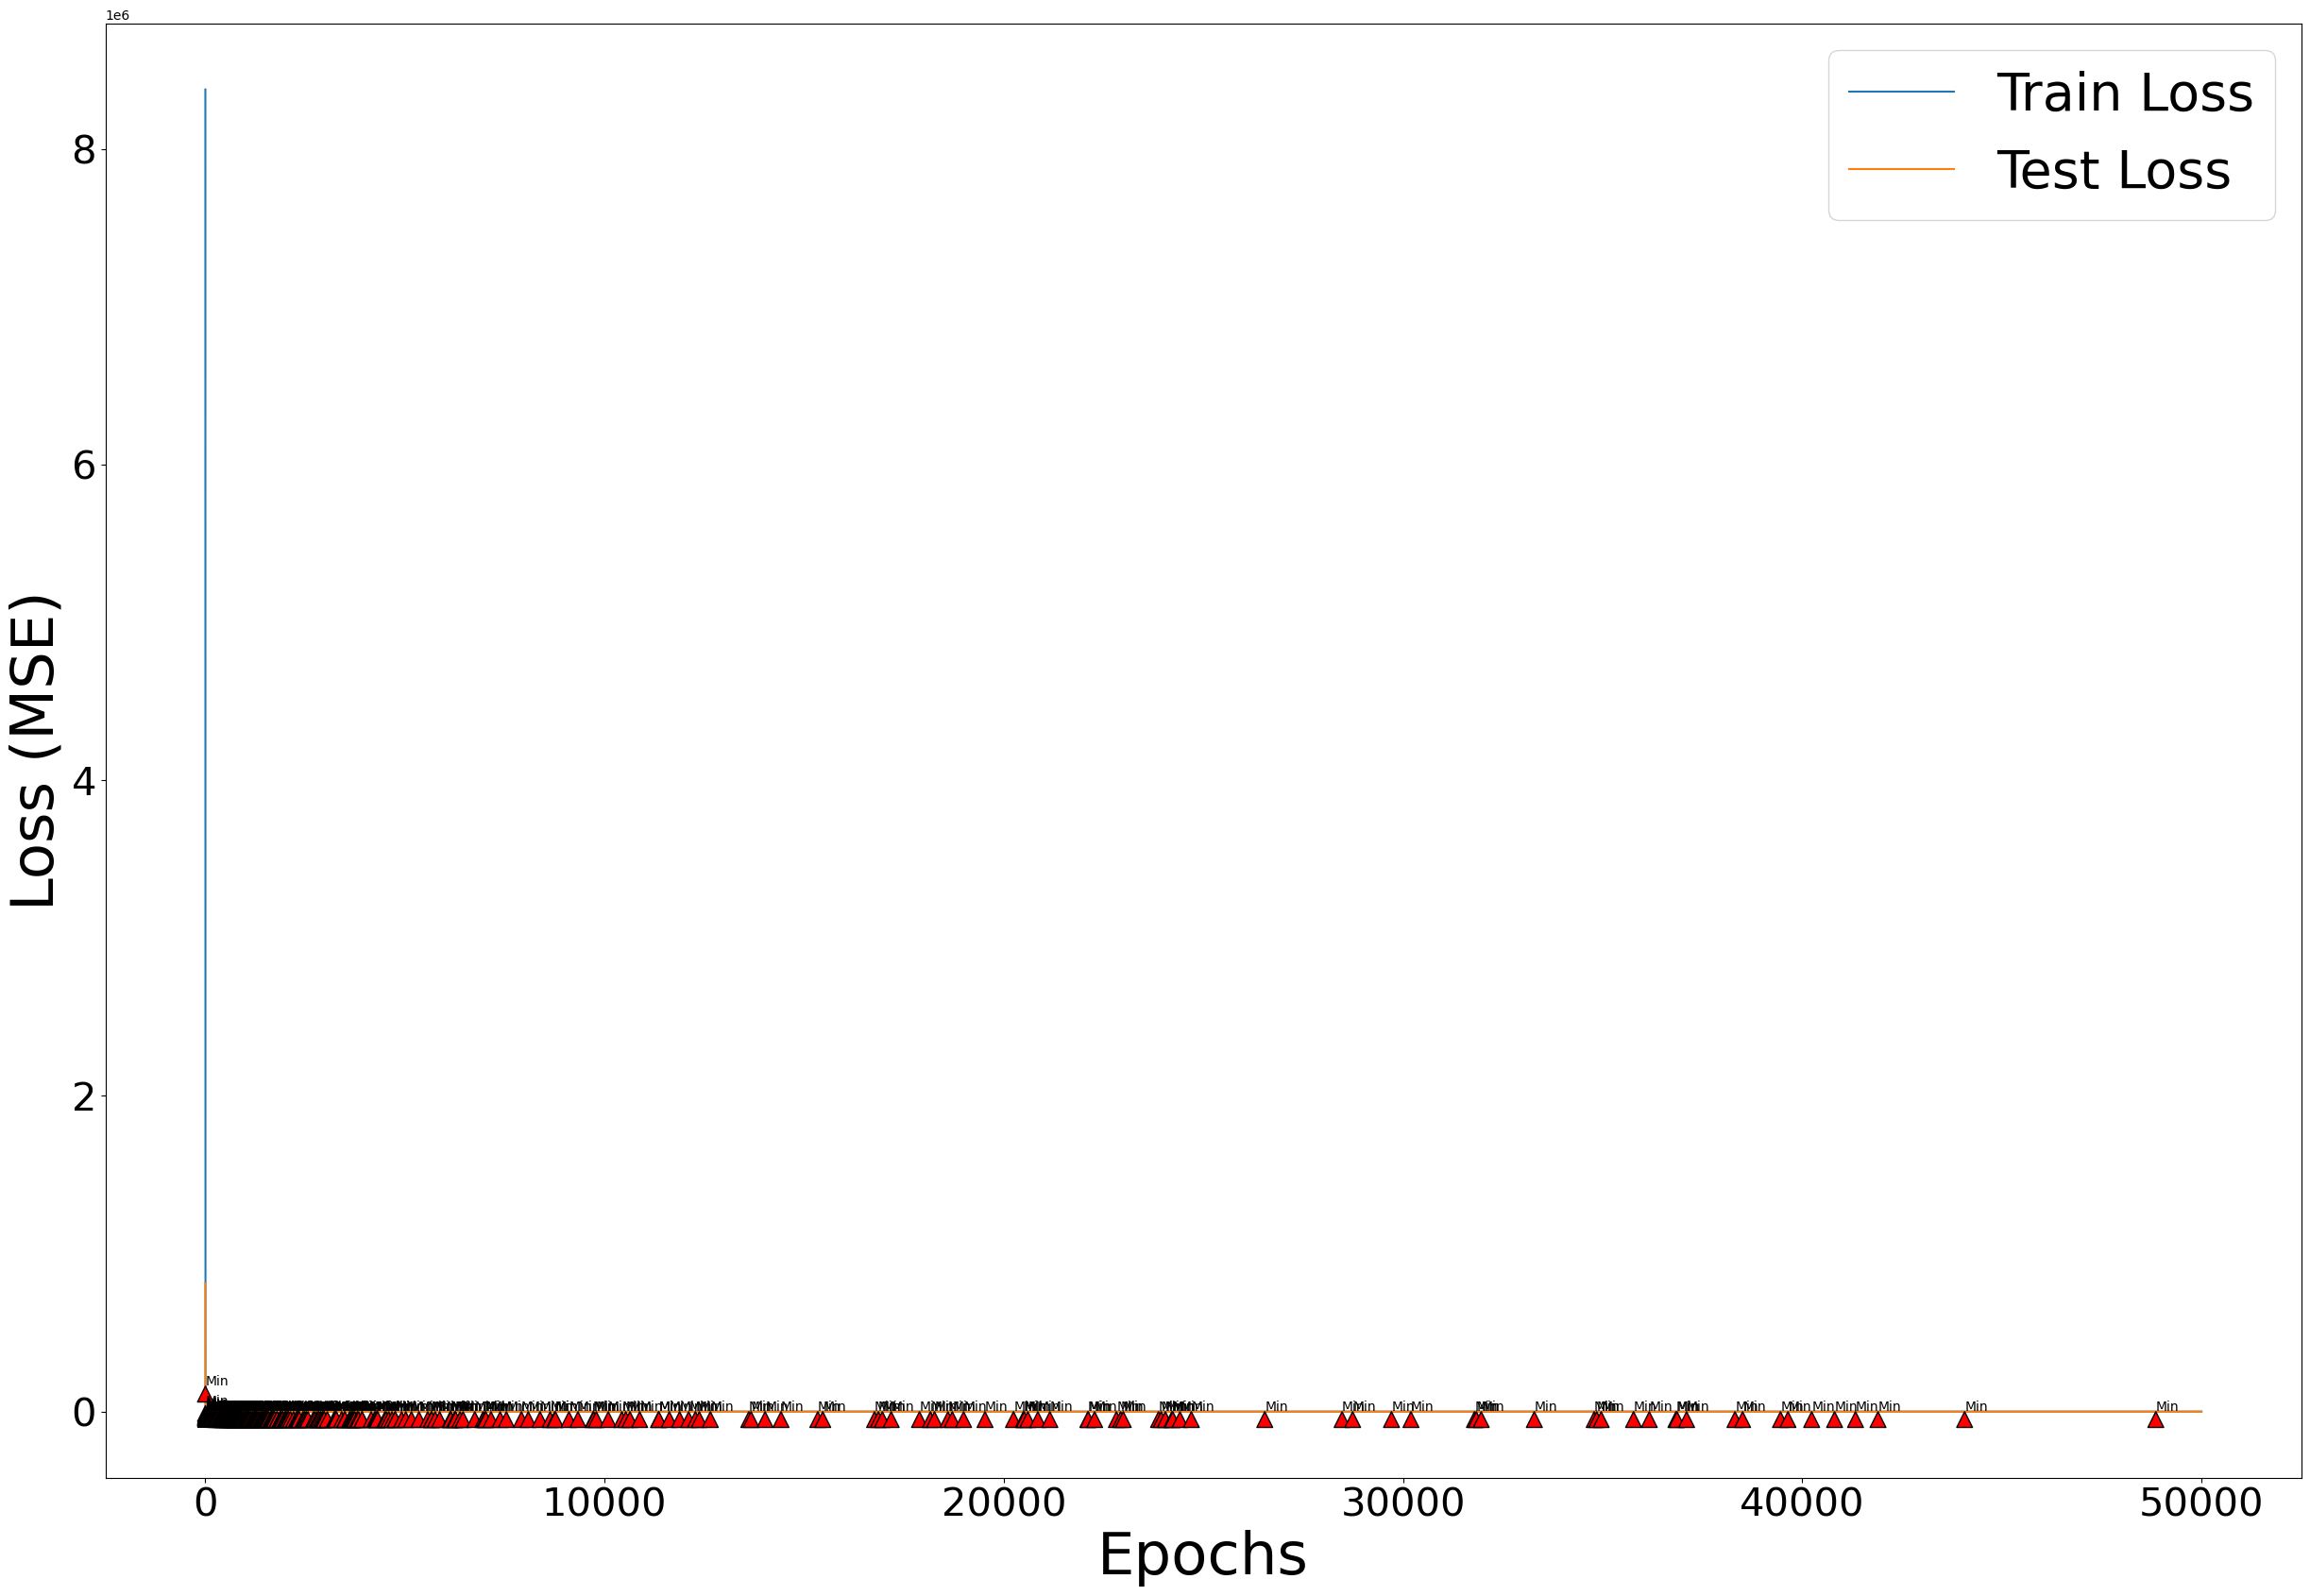

In [129]:

# Plot the data
plt.plot(np.arange(num_epochs)+1, train_losses, label='Train Loss')
plt.plot(np.arange(num_epochs)+1, test_losses, label='Test Loss')

# Track the previous minimum test loss and its index
prev_min_loss = test_losses[0]
prev_min_index = 0

# Annotate each local minimum test loss with arrows
for idx, loss in enumerate(test_losses[1:], start=1):
    if loss < prev_min_loss:
        plt.annotate('Min', xy=(idx+1, loss), xytext=(idx+1, loss + 5000),
                     arrowprops=dict(facecolor='red', shrink=0.05))
        prev_min_loss = loss
        prev_min_index = idx
        
# Add x and y labels
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

# Change axis size
plt.rcParams['axes.labelsize'] = 45  # Change label font size

# Change tick size
plt.tick_params(axis='x', labelsize=30)  # Change tick size for x-axis
plt.tick_params(axis='y', labelsize=30)  # Change tick size for y-axis

# Plot legend, and display figure
plt.legend(fontsize = 40)
plt.show()

In [130]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = NMR_Model_Lipid()

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

NMR_Model_Lipid(
  (lin1): Linear(in_features=14000, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=18, bias=True)
)

In [131]:
## Switch to directory for saving model metrics

os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/ModelPerformanceMetrics')   

In [132]:
## Test model on testing dataset and deterine RMSE

outputs = model_aq(X_train) # Evaluate input spectra with MLP

# Move tensors to CPU and convert to numpy arrays
outputs_cpu = outputs.detach().cpu().numpy()
y_train_cpu = y_train.detach().cpu().numpy()

err = np.sqrt(mean_squared_error(outputs_cpu, y_train_cpu))  # Determine RMSE
print('model err: ', err)  # Print RMSE

np.save(ModelName + "TrainRMSE",err)

model err:  0.015454075


In [133]:
## Test model on testing dataset and deterine RMSE

model_aq.eval() # Change to evaluation mode (maybe not needed for this model)
outputs = model_aq(X_test) # Evaluate input spectra with MLP

# Move tensors to CPU and convert to numpy arrays
outputs_cpu = outputs.detach().cpu().numpy()
y_test_cpu = y_test.detach().cpu().numpy()

err = np.sqrt(mean_squared_error(outputs_cpu, y_test_cpu))  # Determine RMSE
print('model err: ', err)  # Print RMSE

np.save(ModelName + "TestRMSE",err)

model err:  0.06293419


In [134]:
## Test model on validation dataset and deterine RMSE

model_aq.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model_aq(spectraVal)  # Evaluate input spectra with MLP

# Move tensors to CPU and convert to numpy arrays
outputs_cpu = outputs.detach().cpu().numpy()
concVal_cpu = concVal.detach().cpu().numpy()

err = np.sqrt(mean_squared_error(outputs_cpu, concVal_cpu))  # Determine RMSE
print('model err: ', err)  # Print RMSE

np.save(ModelName + "ValRMSE", err)

model err:  0.06789579


In [135]:
ExpValConc.shape

torch.Size([11, 18])

In [136]:
ExpValSpectra.squeeze(dim=2).shape

torch.Size([11, 14000])

In [137]:
APEs = []
MAPEs = []

for i in np.arange(11):
    GroundTruth = ExpValConc[i].detach().cpu().numpy()
    Prediction = model_aq(ExpValSpectra.squeeze(dim=2)[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for LipidGroup in range(18):
        per_err = 100*(GroundTruth[LipidGroup] - Prediction_cpu[LipidGroup]) / GroundTruth[LipidGroup]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)

# Correct the MAPE for the example input with 4 of 8 metabolites present
MAPEs[4] = (APEs[4][0] + APEs[4][1] + APEs[4][4] + APEs[4][6]) / 4

# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))


/tmp/ipykernel_134731/2375053133.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  per_err = 100*(GroundTruth[LipidGroup] - Prediction_cpu[LipidGroup]) / GroundTruth[LipidGroup]


In [138]:
APEs

[[5.686122683185403,
  4.827931092690565,
  23.132891967873316,
  5.625238002032372,
  1.4721301596107763,
  5.023281805619968,
  10.816735535053724,
  1.4116912696666366,
  2.2956115867321167,
  5.023288055014167,
  2.3446663195710067,
  2.9291381260671905,
  37.26467486938877,
  12.176492018604044,
  6.0282216397545,
  49.7682164724869,
  inf,
  inf],
 [6.0851619343815395,
  8.320380380320598,
  11.838078506415862,
  5.961663824291341,
  2.949016403330643,
  2.770289526275983,
  11.167332895633534,
  0.3591670160663986,
  4.085821647956105,
  2.7702598167232546,
  4.006053005638536,
  4.940453882364847,
  11.380626686604254,
  6.539716163157614,
  0.0513370786930004,
  16.257495988700413,
  inf,
  inf],
 [3.596401600394766,
  11.873536077628374,
  12.926490458541018,
  4.927502718089123,
  3.111342999398882,
  2.9866150018662223,
  10.976331548170545,
  0.46775241988579036,
  4.24601889648104,
  2.9866424597746217,
  3.4512625448106786,
  7.688916827969115,
  12.143621685010299,
  9.